# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import inflection
import math
from datetime import datetime , timedelta
from IPython.core.display import HTML
from IPython.display import Image
import warnings
from scipy  import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import random
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

In [2]:
def cramer_v(x,y):

    cm = pd.crosstab(x,y).values

    n=cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2_corr = max(0 , chi2 - (k-1) * (r-1)/(n-1))
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)

    v = np.sqrt( ( chi2_corr/n ) / ( min( k_corr-1 , r_corr-1 )))

    return v

def ml_error( model_name, y , yhat):
    
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt( mean_squared_error(y,yhat) )

    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse
                        }, index=[0] )

def time_cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range( 1, kfold+1)):

        if verbose: 
            print(f'KFold Number: {k}' )
        # start and end date for validation
     
        validation_start_date = x_training['date'].max() - timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - timedelta( days=k-1*6*7 )

        # filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training and validation dataset
        xtraining = training.drop( [ 'date', 'sales' ], axis=1 )
        ytraining = training['sales']

        xvalidation = validation.drop( [ 'date', 'sales' ], axis=1 )
        yvalidation = validation['sales']

        #model
        modelo = model.fit( xtraining, ytraining)

        #prediction
        yhat_model = modelo.predict( xvalidation )

        #performance
        model_result = ml_error ( model_name, np.expm1( yvalidation ) , np.expm1( yhat_model ))

        #store performance
        mae_list.append(model_result['MAE'])
        mape_list.append(model_result['MAPE'])
        rmse_list.append(model_result['RMSE'])

    return pd.DataFrame({
                'Model_NAME': model_name,
                'MAE CV': np.round( np.mean( mae_list ) , 2 ).astype( str ) + '+/-' + np.round( np.std( mae_list ), 2 ).astype( str ),
                'MApE CV': np.round( np.mean( mape_list ) , 2 ).astype( str ) + '+/-' + np.round( np.std( mape_list ), 2 ).astype( str ),
                'RMSE CV': np.round( np.mean( rmse_list ) , 2 ).astype( str ) + '+/-' + np.round( np.std( rmse_list ), 2 ).astype( str )
                }, index=[0])

## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('../data/train.csv')
df_store_raw = pd.read_csv('../data/store.csv')

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descricao dos Dados

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
df1 = df_raw.copy()

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

df1.columns = cols_new

## 1.2 Data Diemnsions

In [8]:
df1.shape

(1017209, 18)

## 1.3 Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

df1.dtypes

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
#competition_distance

df1['competition_distance'] = df1['competition_distance'].apply( lambda x:  200000.00 if math.isnan( x ) else x)
 
#competition_open_since_month

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month' ]) else x['competition_open_since_month'], axis=1)

#competition_open_since_year

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year' ]) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week' ]) else x['promo2_since_week'], axis=1)


#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year' ]) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[[ 'promo_interval','month_map' ]].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in  x['promo_interval'].split( ',' ) else 0, axis=1 )


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descritptive Statistical

In [19]:
num_atributes = df1.select_dtypes( include=[ 'int64' , 'float64' ] )
cat_atributes = df1.select_dtypes( exclude=[ 'int64' , 'float64' , 'datetime64[ns]' ] )

In [20]:
num_atributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
366754,486,4,3528,513,1,0,1,2320.0,8,2014,1,31,2013,0
740368,794,5,2829,510,1,0,0,5090.0,9,2006,0,36,2013,0


In [21]:
cat_atributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
85187,0,a,c,0,May
474808,0,d,a,0,May


### 1.7.1 Numerical Atributes

In [22]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_atributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_atributes.apply( np.median ) ).T

# Disprsion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_atributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_atributes.apply( min ) ).T
d3 = pd.DataFrame( num_atributes.apply( max ) ).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [ d2 , d3 , d4 ,ct1 , ct2 , d1 , d5 , d6 ] ).T.reset_index()
m.columns = [ 'Atributes','min', 'max', 'range', 'mean', 'meadian', 'std', 'skew', 'kurtosis']

In [23]:
m

,Atributes,min,max,range,mean,meadian,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Density'>

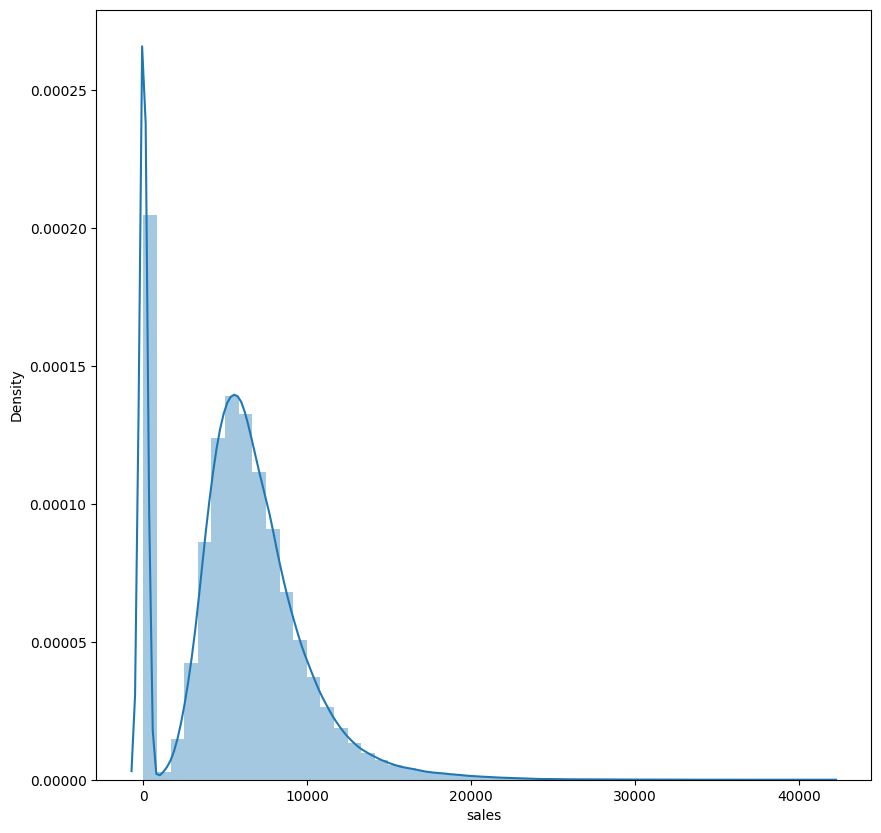

In [24]:
plt.figure(figsize=(10, 10))
sns.distplot( df1['sales'] )

<Axes: xlabel='competition_distance', ylabel='Density'>

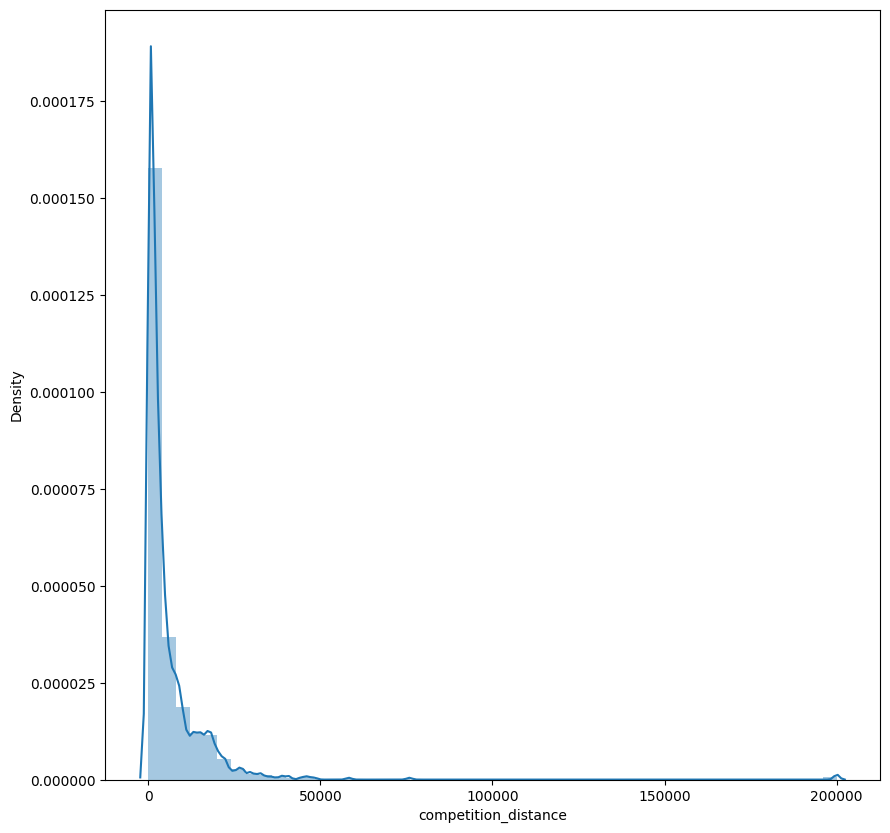

In [25]:
plt.figure(figsize=(10, 10))
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Atributes

In [26]:
cat_atributes.apply( lambda x: x.unique().shape[0] )

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

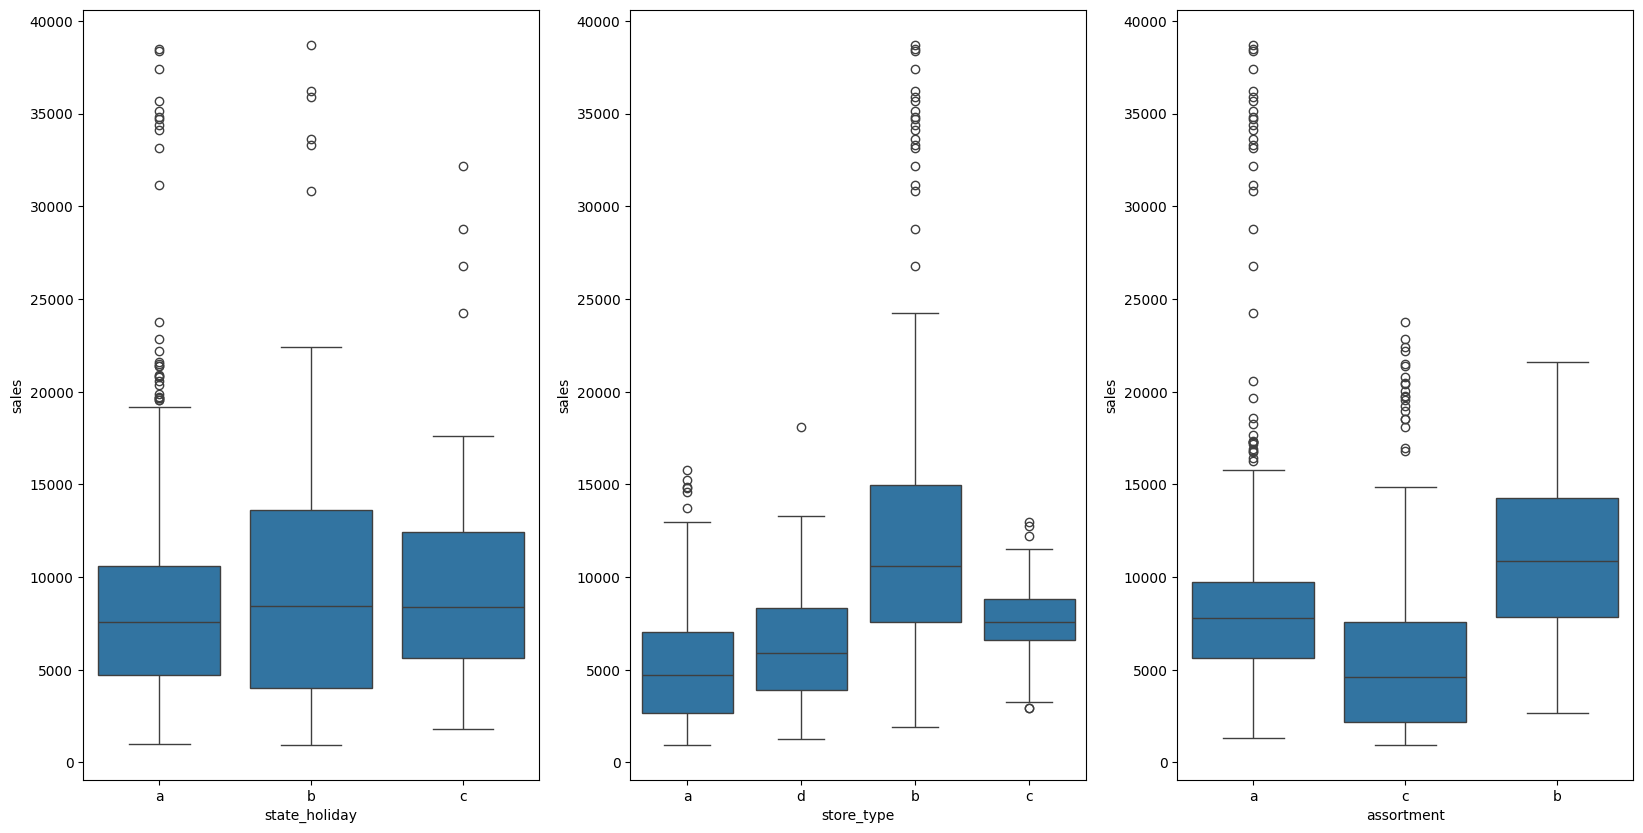

In [27]:
aux1 = df1[ ( df1['state_holiday'] != 0 ) & ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ] 

plt.figure(figsize=[20,10])

plt.subplot( 1,3,1 )
sns.boxplot( x='state_holiday' , y='sales' , data=aux1)

plt.subplot( 1,3,2 )
sns.boxplot( x='store_type' , y='sales' , data=aux1)

plt.subplot( 1,3,3 )
sns.boxplot( x='assortment' , y='sales' , data=aux1)

# 2.0 Feature Engineering

 ## 2.1. Mapa Mental de Hipoteses

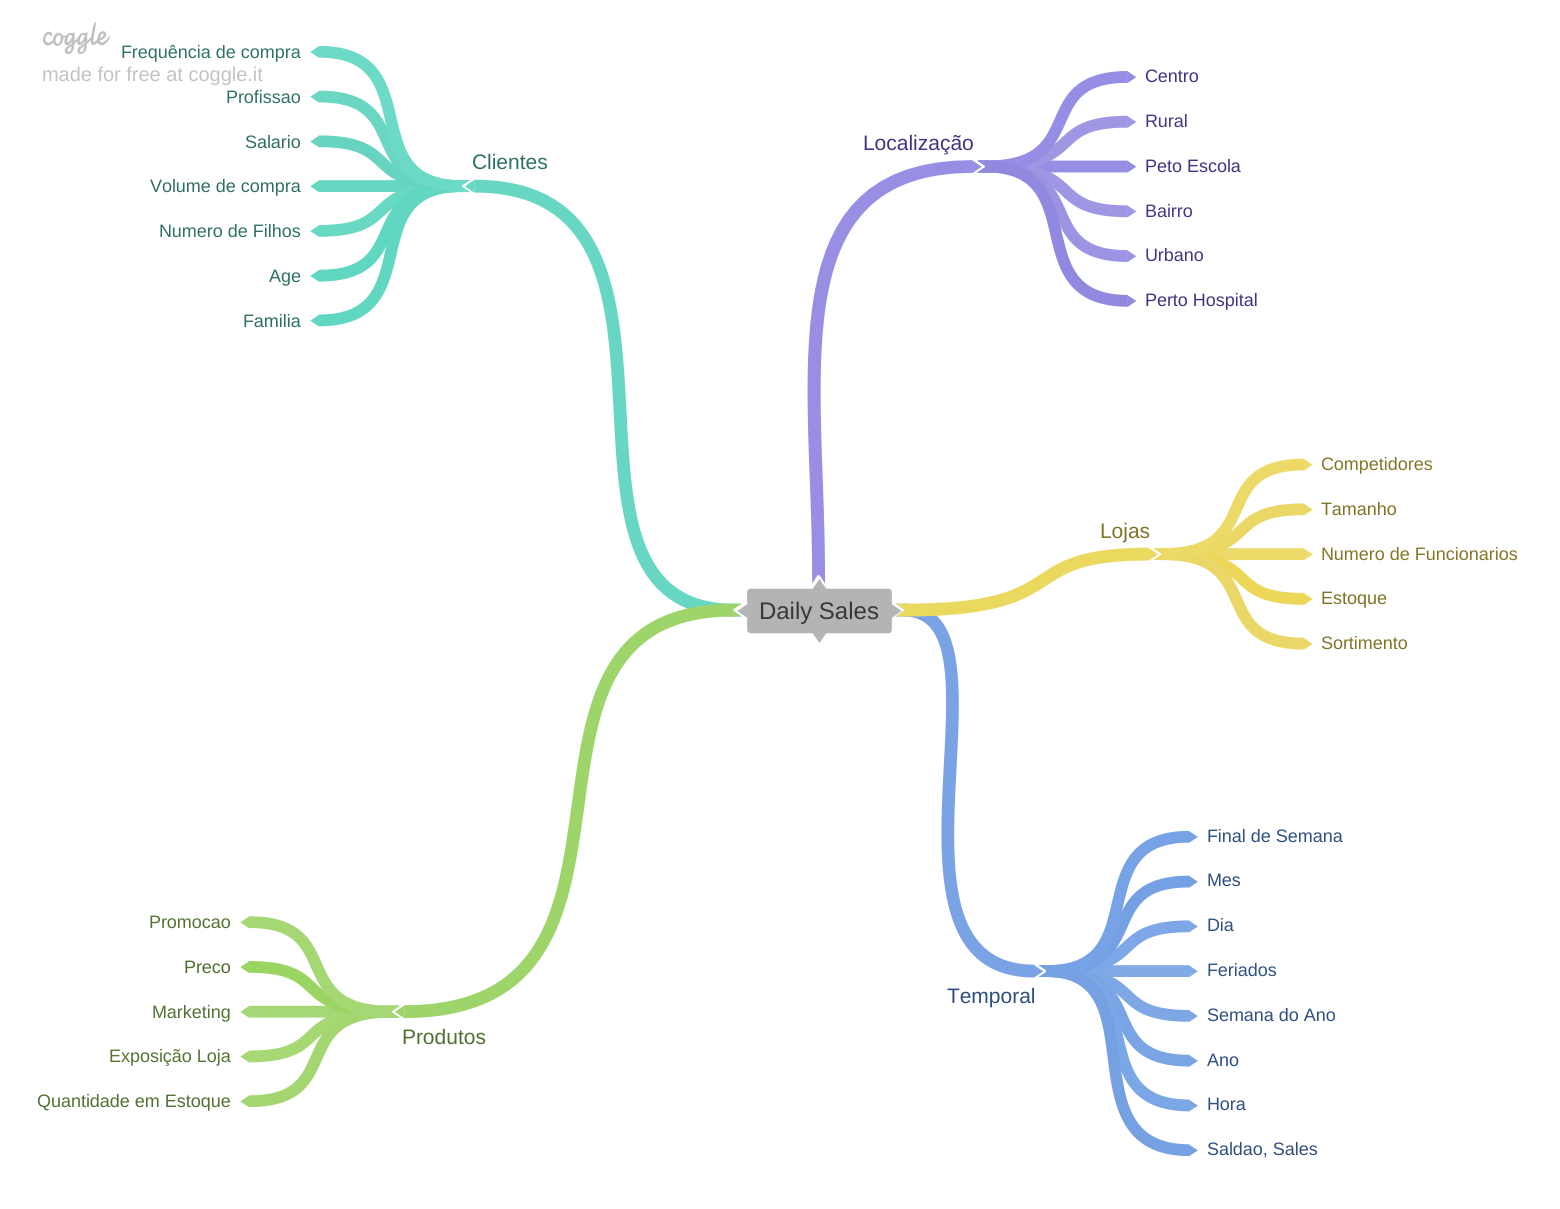

In [28]:
Image( '../images/Daily_Sales.png')

## 2.2. Criação das hipoteses

### 2.2.1 Hipoteses da Loja

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses do Produto

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses do Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [29]:
df2 = df1.copy()

# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition Since
df2['competition_since'] = df2.apply(lambda i: datetime(year=i['competition_open_since_year'], month=i['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda i: i.days ).astype( int )

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime( x + '-1', '%Y-%W-%w') - timedelta( days=7 ))
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7).apply( lambda i: i.days ).astype( int )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda i: 'basic' if i == 'a' else 'extra' if i == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda i: 'public_holliday' if i == 'a' else 'easter_holliday' if i == 'b' else 'christimas' if  i == 'c' else 'regular_day')

In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [31]:
df3 = df2.copy()

In [32]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1. Filtragem de Colunas

In [33]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Selecao de Colunas

In [34]:
df3 = df3.drop(['customers' , 'open' , 'promo_interval' , 'month_map'], axis=1)
df3.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 AED

In [35]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Variavel Resposta

<Figure size 2000x1000 with 0 Axes>

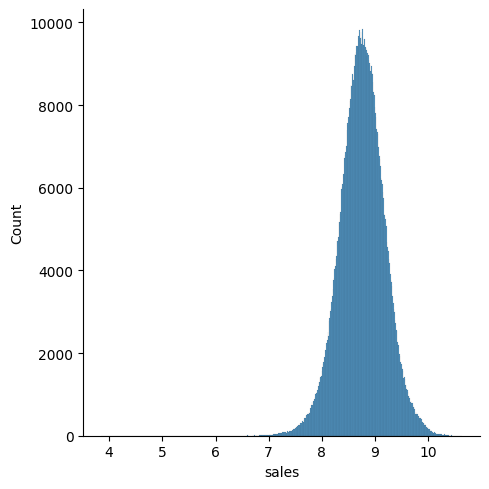

In [36]:
plt.figure(figsize=(20,10))
sns.displot( np.log1p(df4['sales']))

### 4.1.2 Vairiaveis numericas

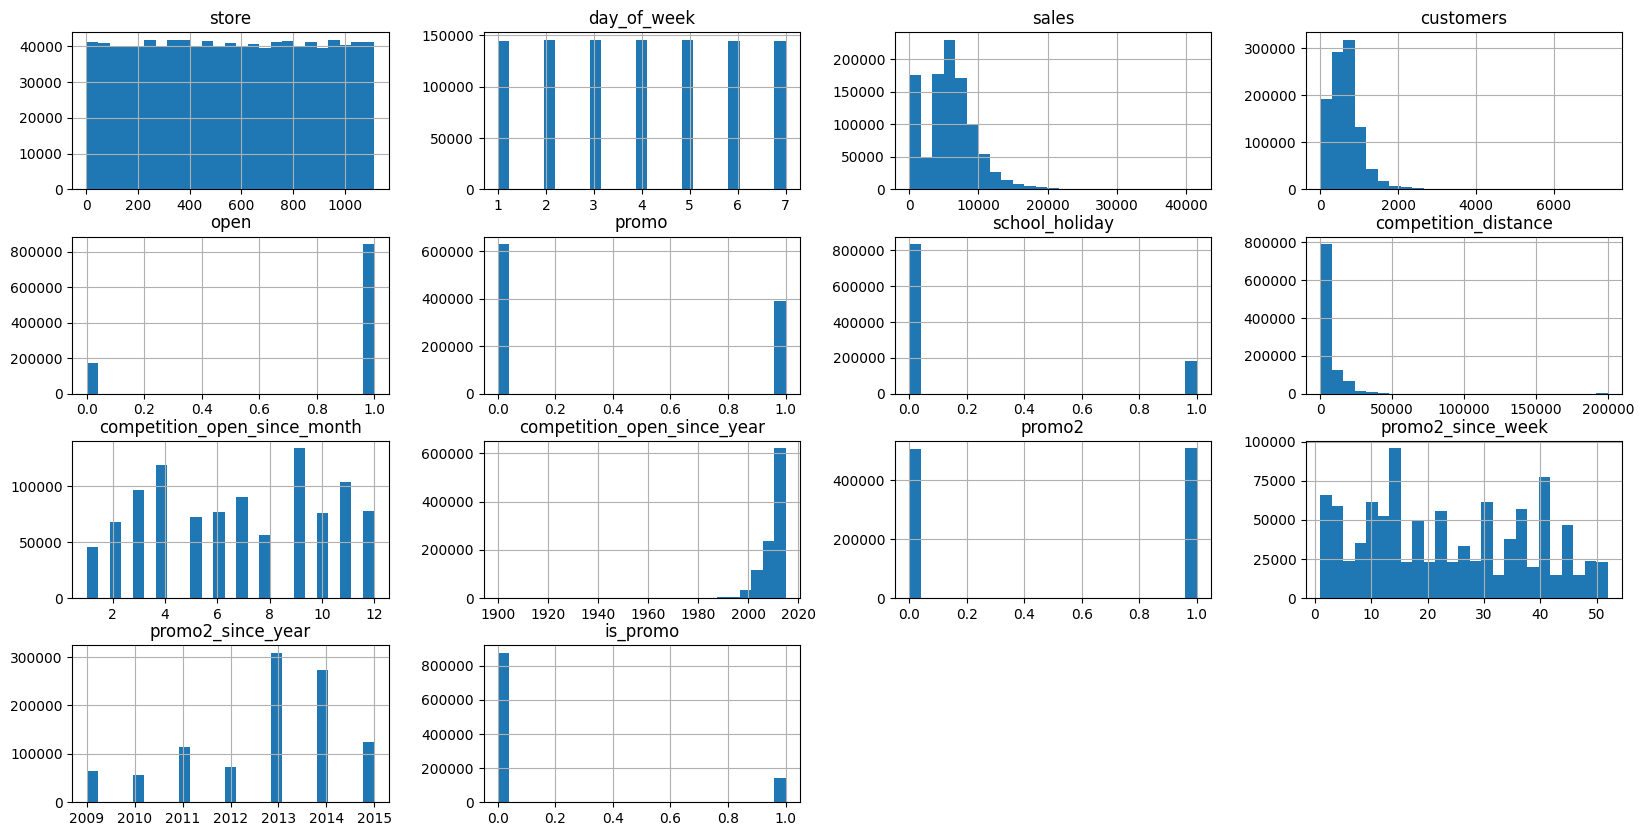

In [37]:
num_atributes.hist(bins=25,figsize=(20,10));

### 4.1.3 Variaveis Categoricas

<Axes: xlabel='sales', ylabel='Density'>

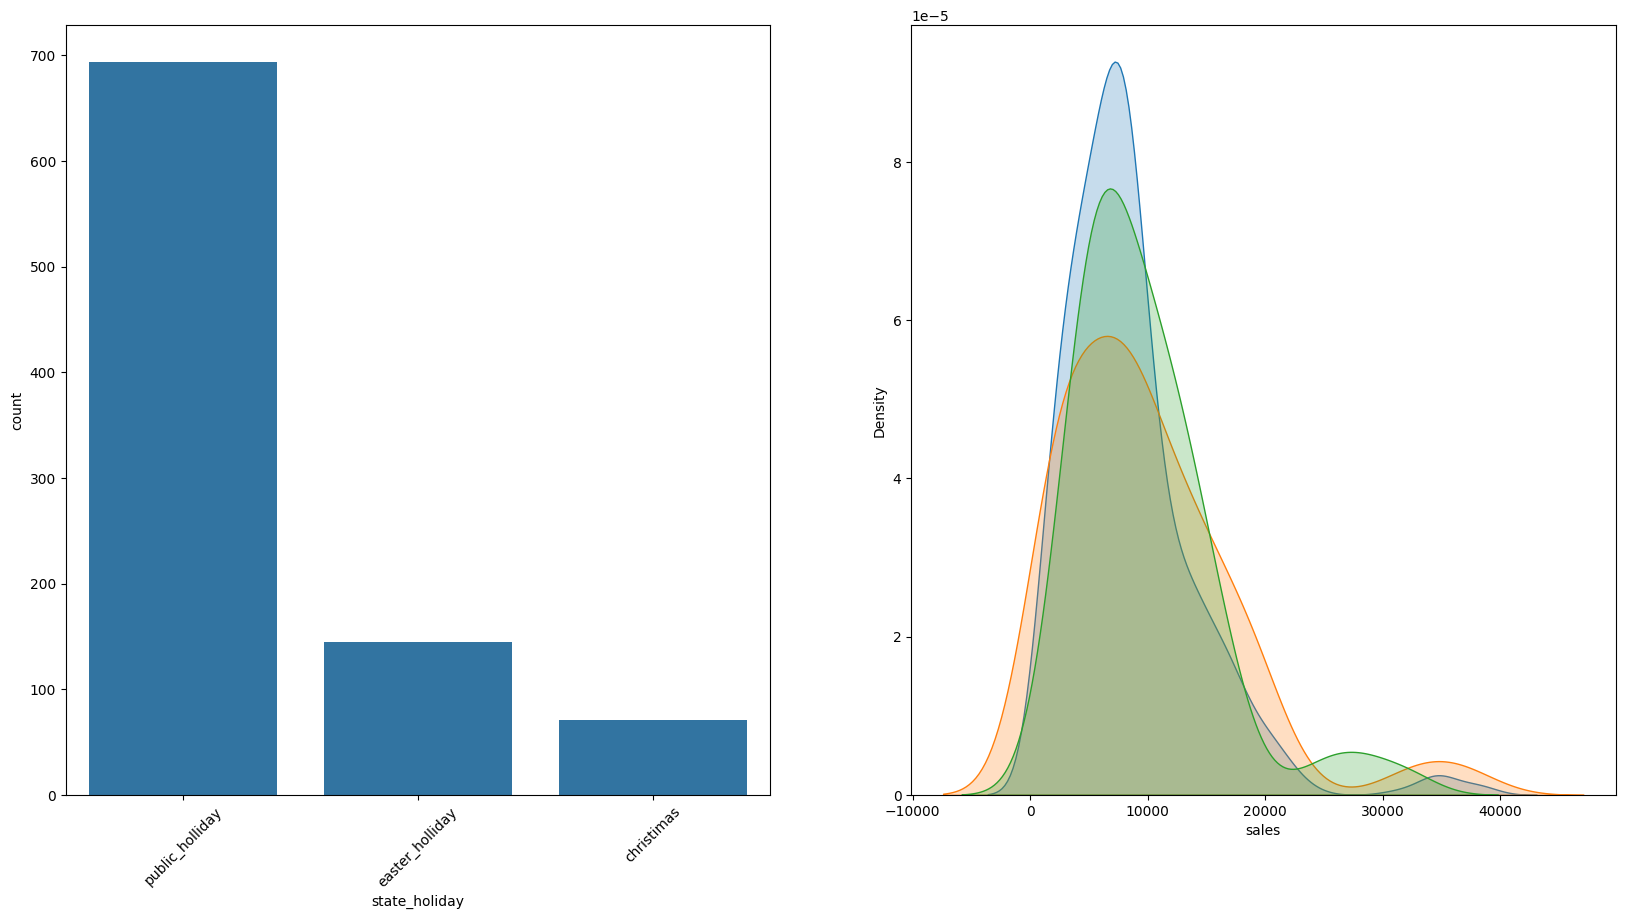

In [38]:
plt.figure(figsize=(20,10))
plt.subplot( 1,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday')
plt.xticks(rotation = 45)
plt.subplot( 1,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holliday']['sales'], label='public_holiday' ,shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holliday']['sales'], label='easter_holliday' ,shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christimas']['sales'], label='christimas' ,shade=True)



<Axes: xlabel='sales', ylabel='Density'>

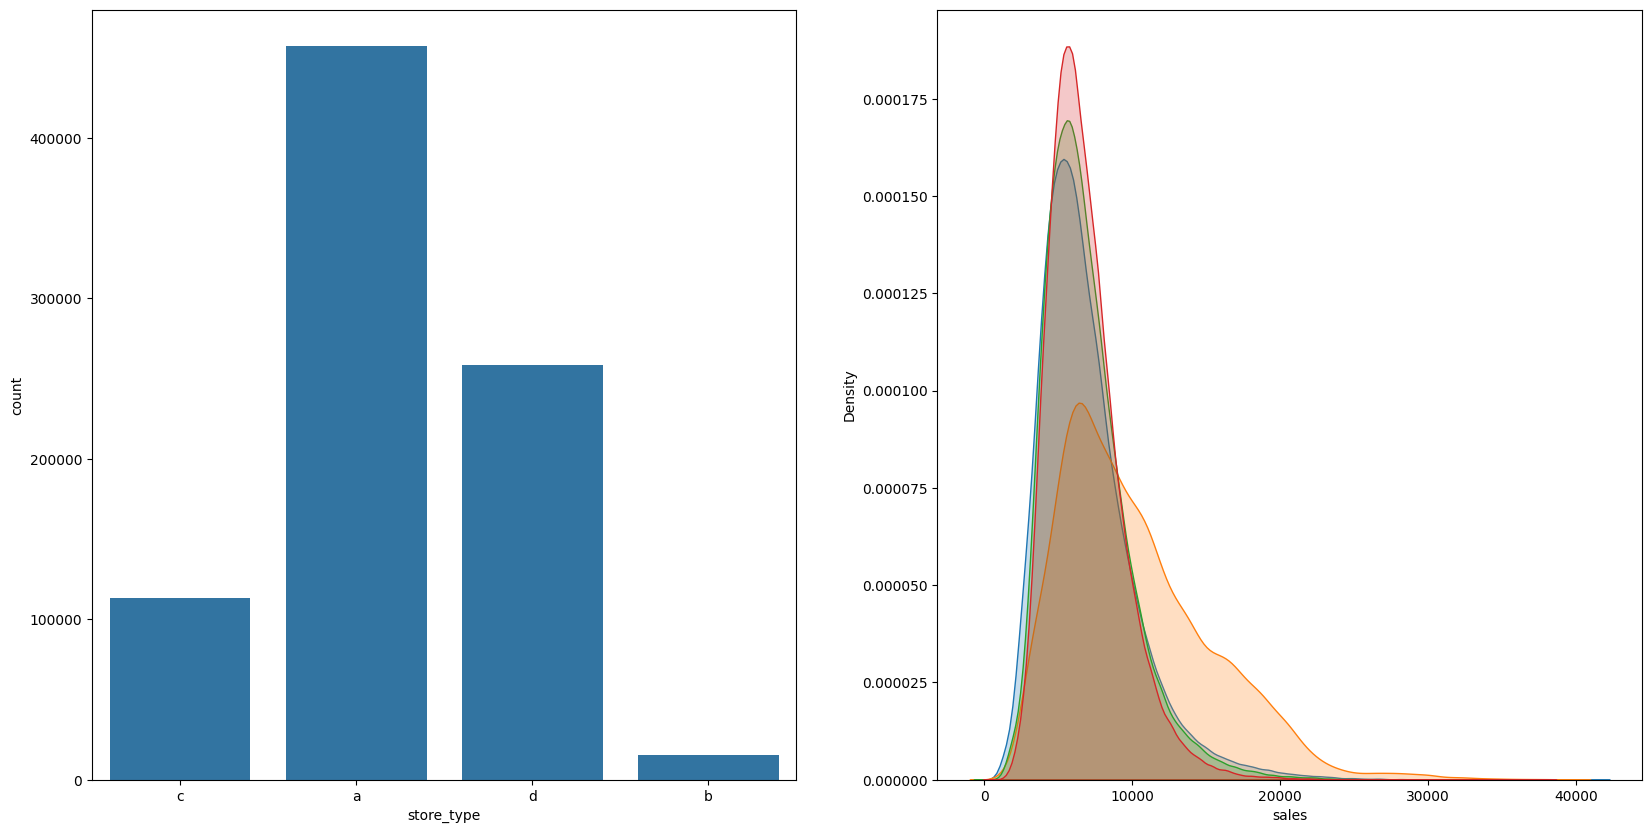

In [39]:
plt.figure(figsize=(20,10))
plt.subplot( 1,2,1)
sns.countplot(data=df4, x='store_type')
plt.subplot( 1,2,2)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a' ,shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b' ,shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c' ,shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d' ,shade=True)

<Axes: xlabel='sales', ylabel='Density'>

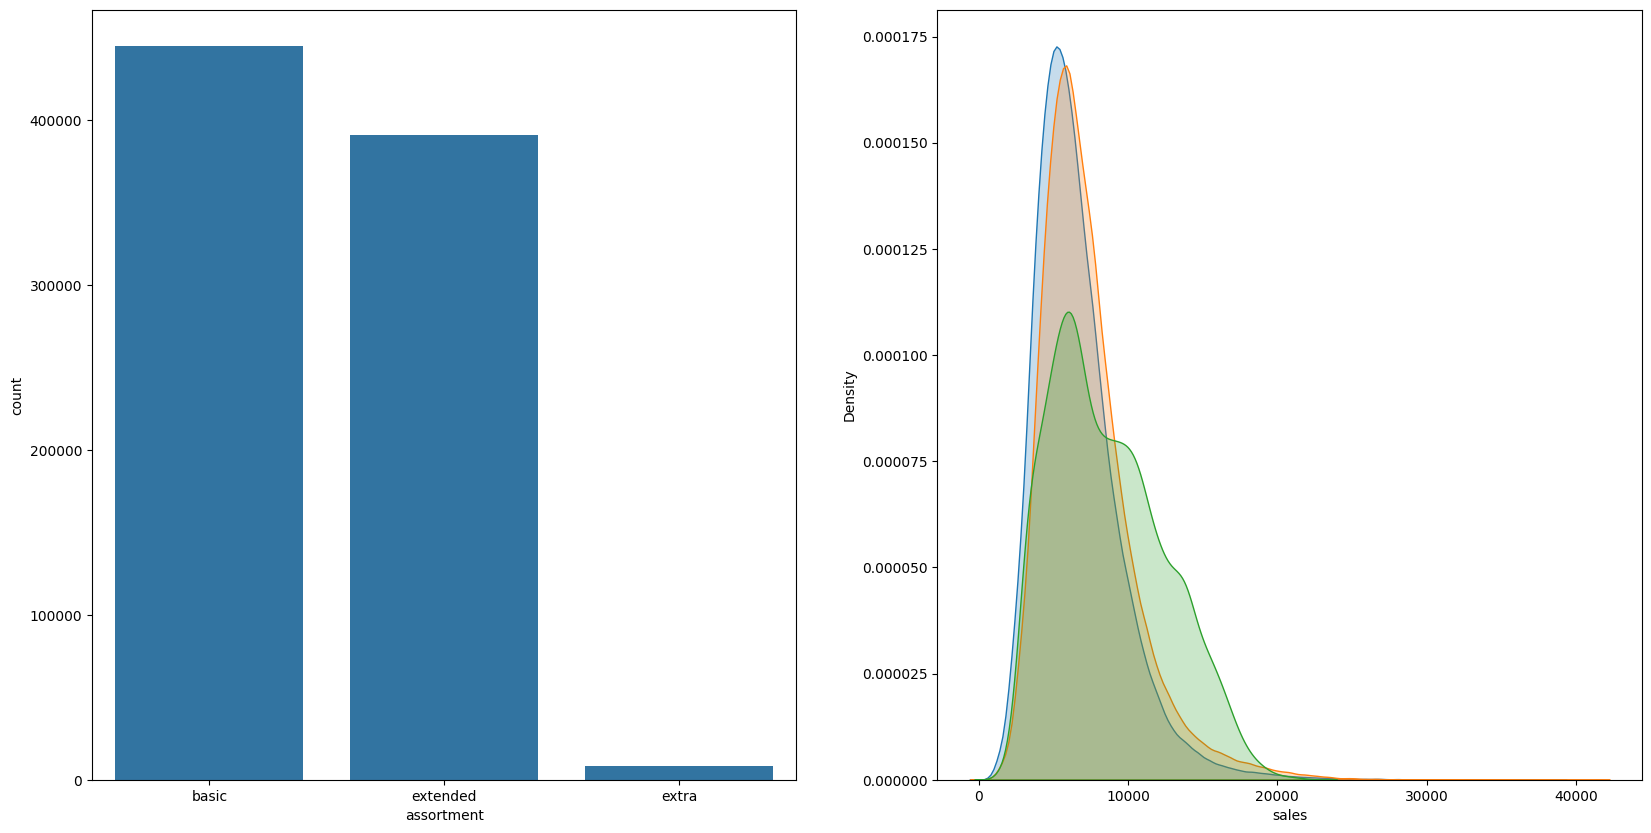

In [40]:
plt.figure(figsize=(20,10))
plt.subplot( 1,2,1)
sns.countplot(data=df4, x='assortment')
plt.subplot( 1,2,2)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic' ,shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended' ,shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra' ,shade=True)

## 4.2 Bivariada

### H1 Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas coom Maior Sortimento Vendem Menos

<Axes: xlabel='year_week'>

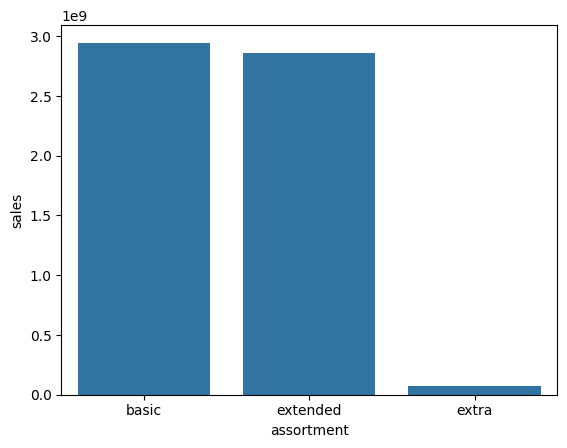

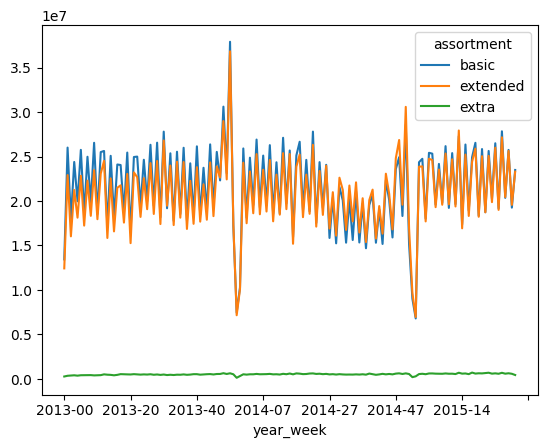

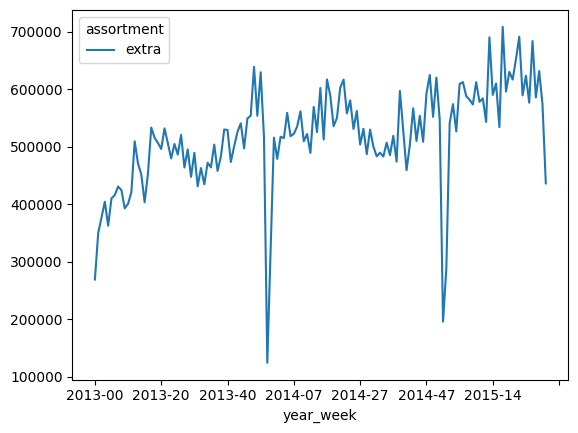

In [41]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()

sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux2[ aux2['assortment'] =='extra'].pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais proximos vendem mais

In [42]:
aux1

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


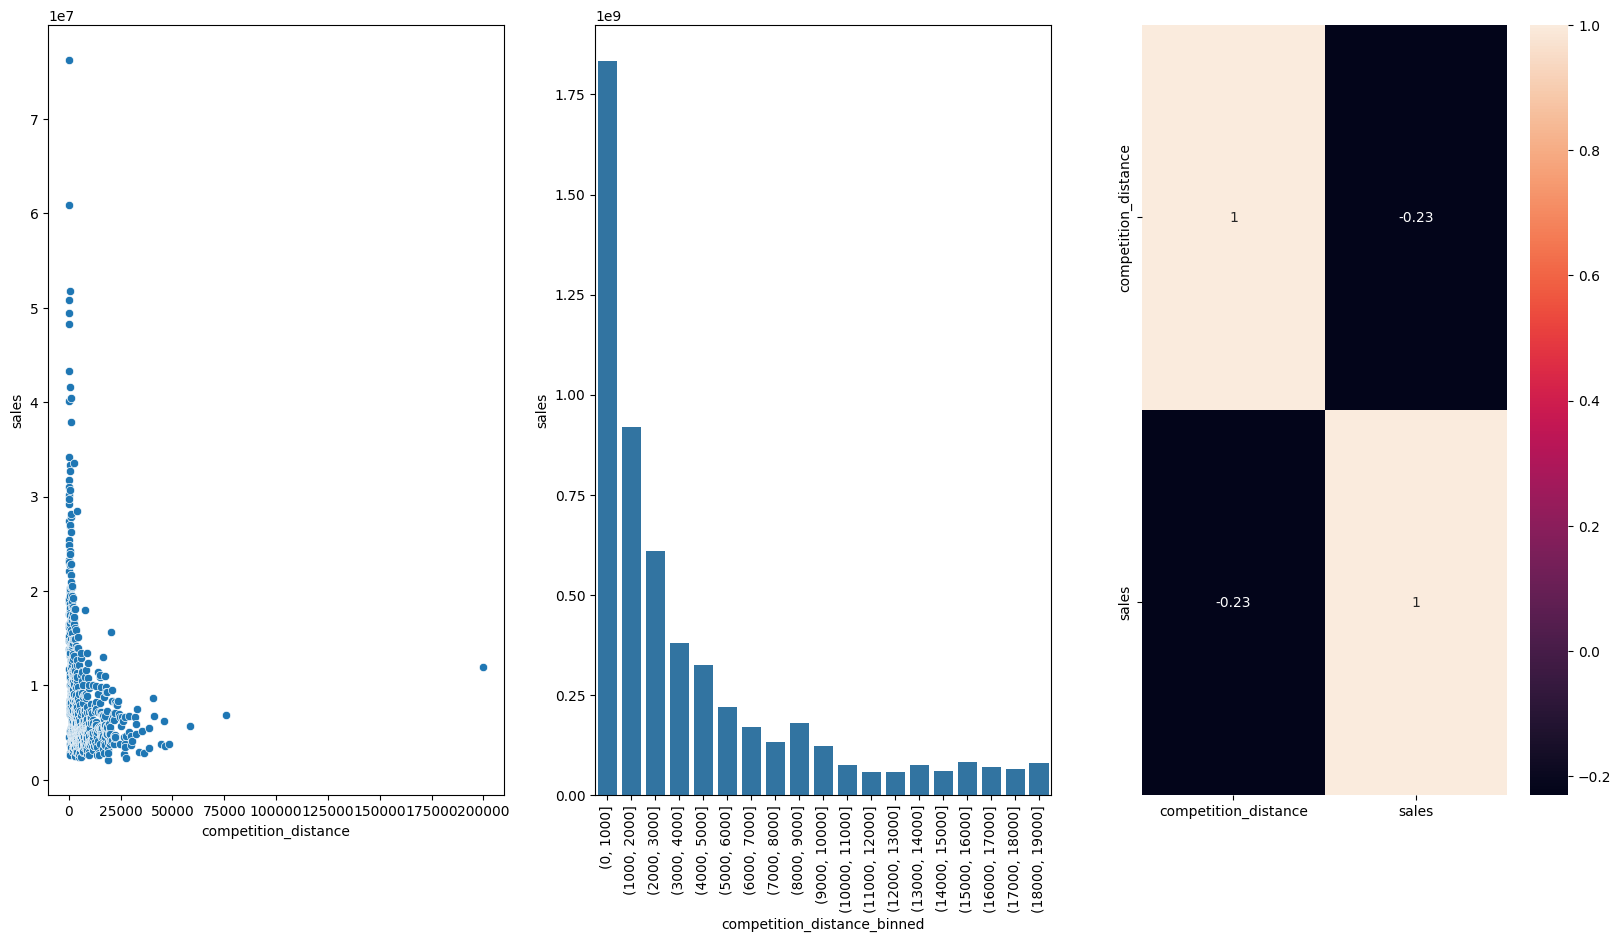

In [43]:
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'] , bins=bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

sns.barplot(x='competition_distance_binned',y='sales', data=aux2);

plt.xticks(rotation=90)

plt.subplot(1,3,3)

sns.heatmap( aux1[['competition_distance','sales']].corr(method='pearson'),annot=True );

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSO** Lojas com competidores a mais tempo vendem menos

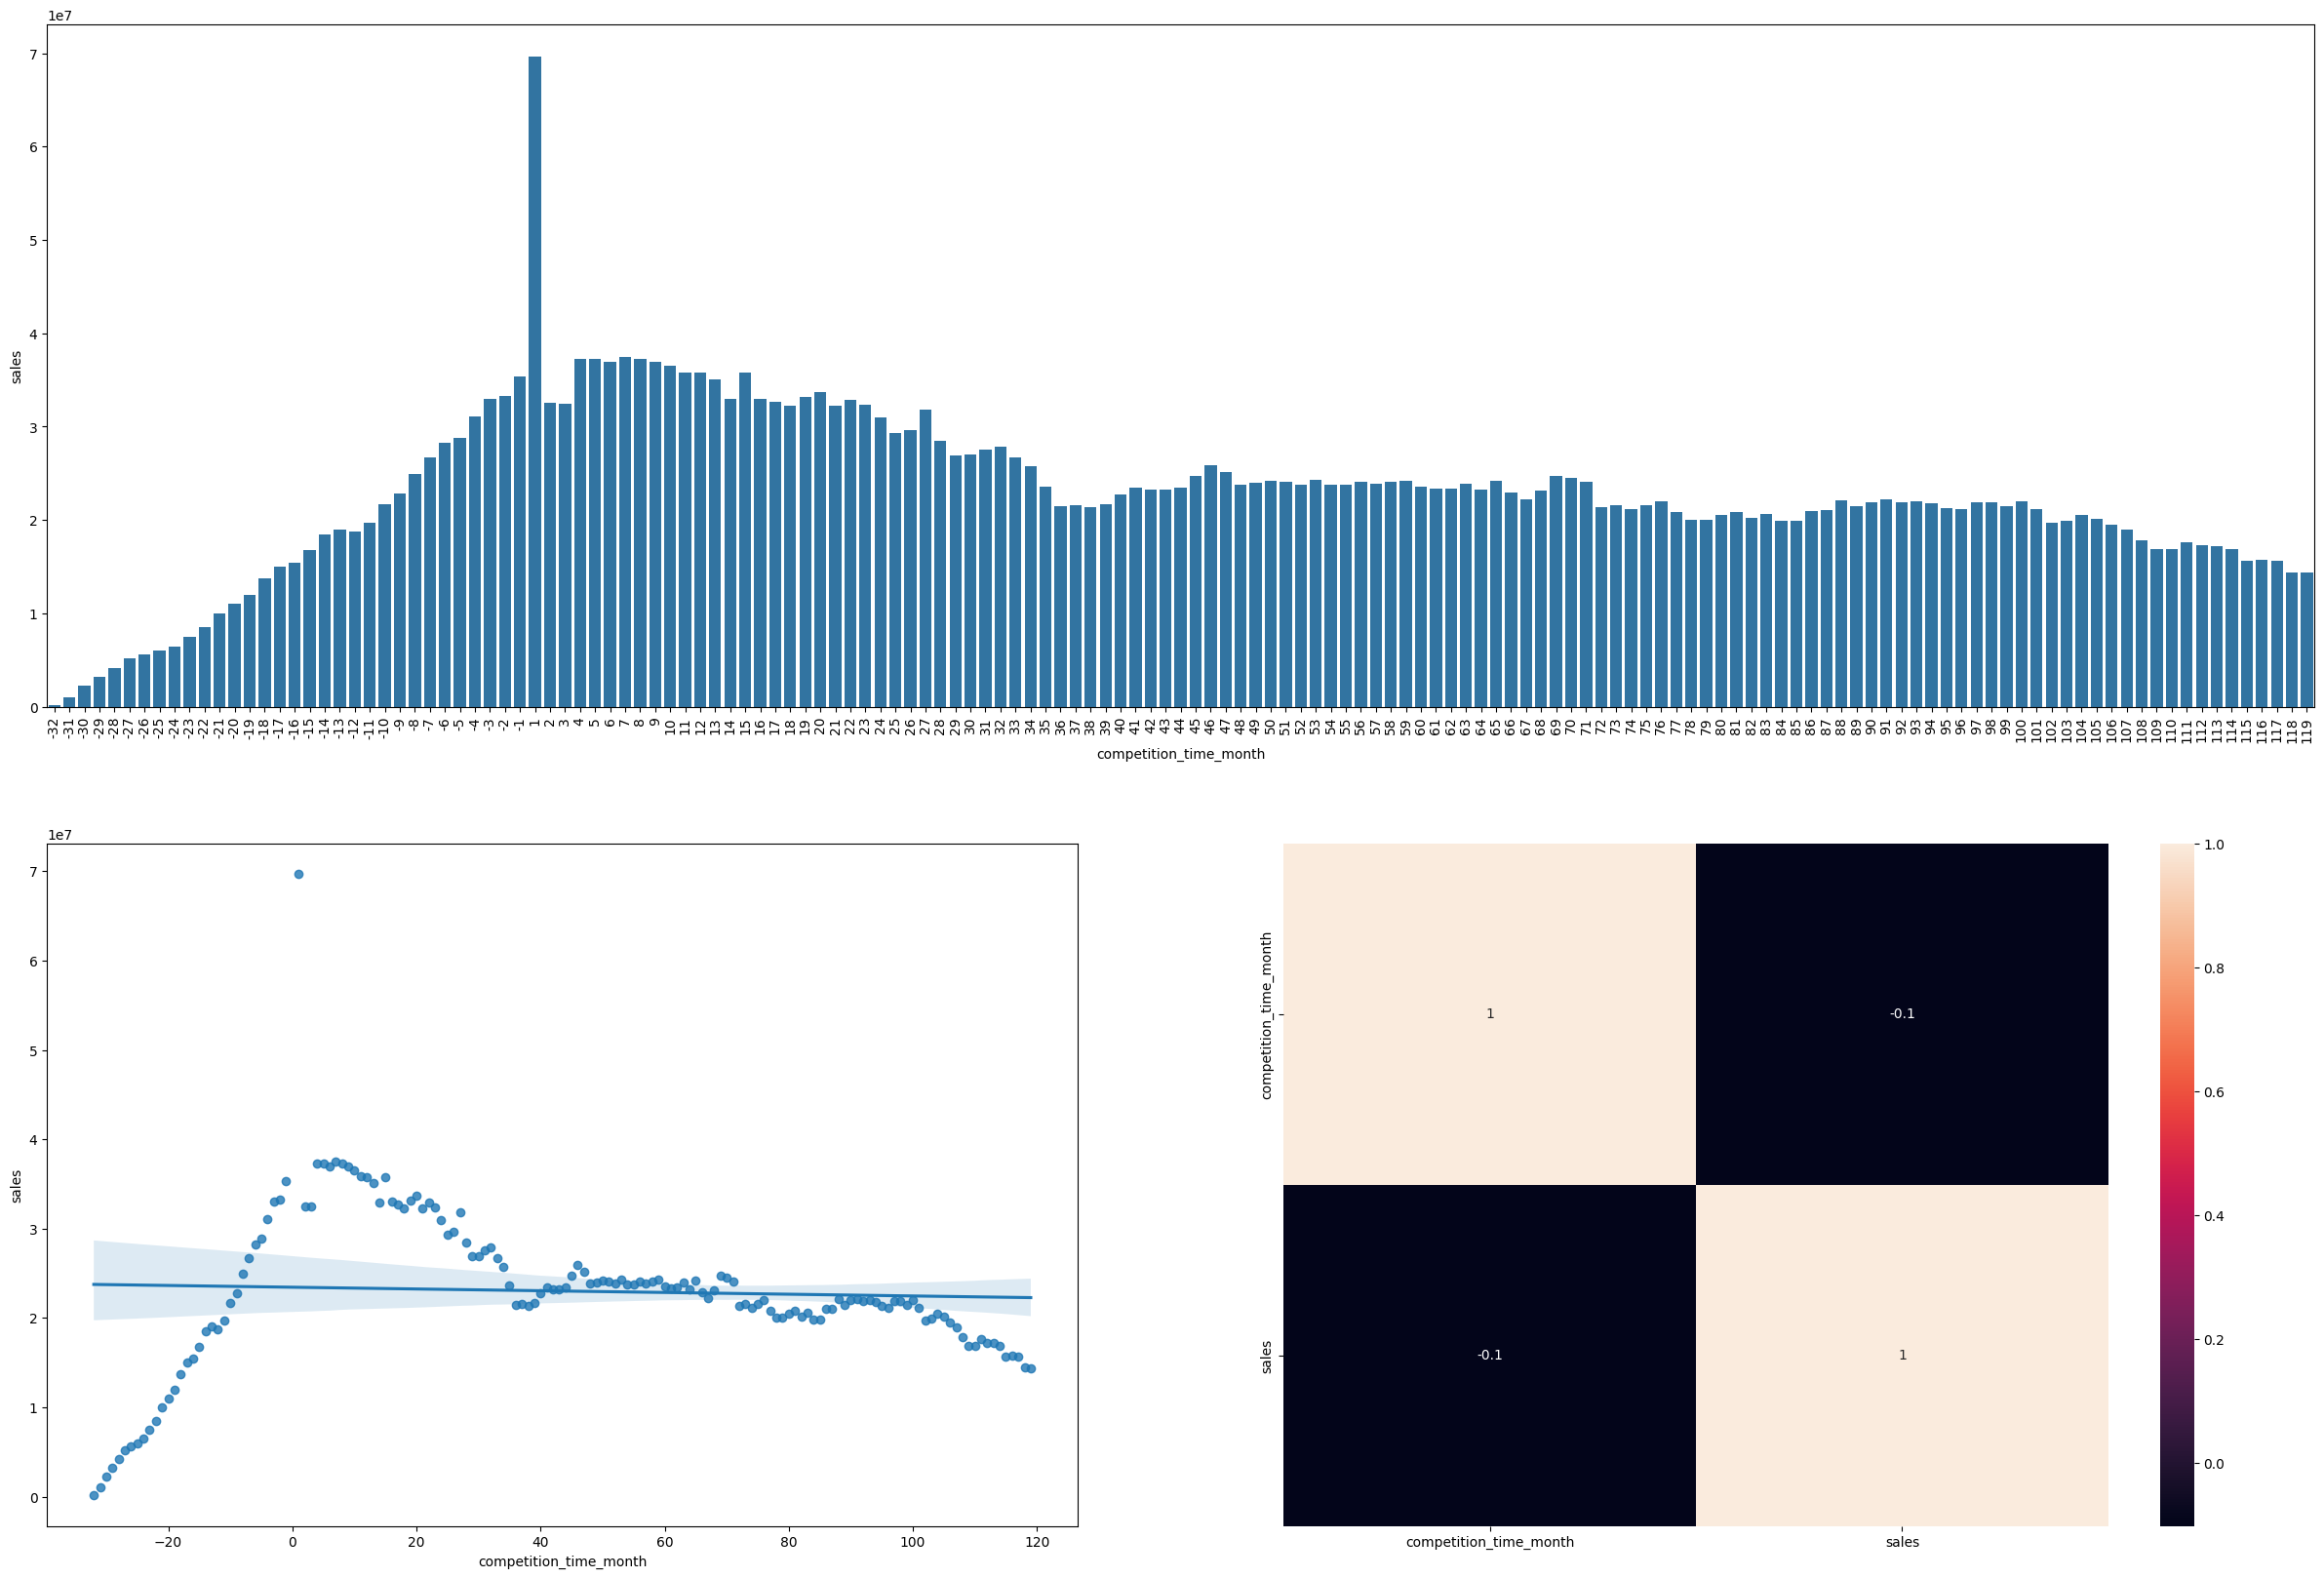

In [44]:
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

plt.figure(figsize=(30, 20))
plt.subplot(2, 1, 1)
sns.barplot(x='competition_time_month',y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(2,2,3)
sns.regplot(x='competition_time_month',y='sales', data=aux2)
plt.subplot(2,2,4)
sns.heatmap( aux1.corr(method='pearson'), annot=True)
plt.show()

### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promoção por mais tempo passama vender menos

In [45]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

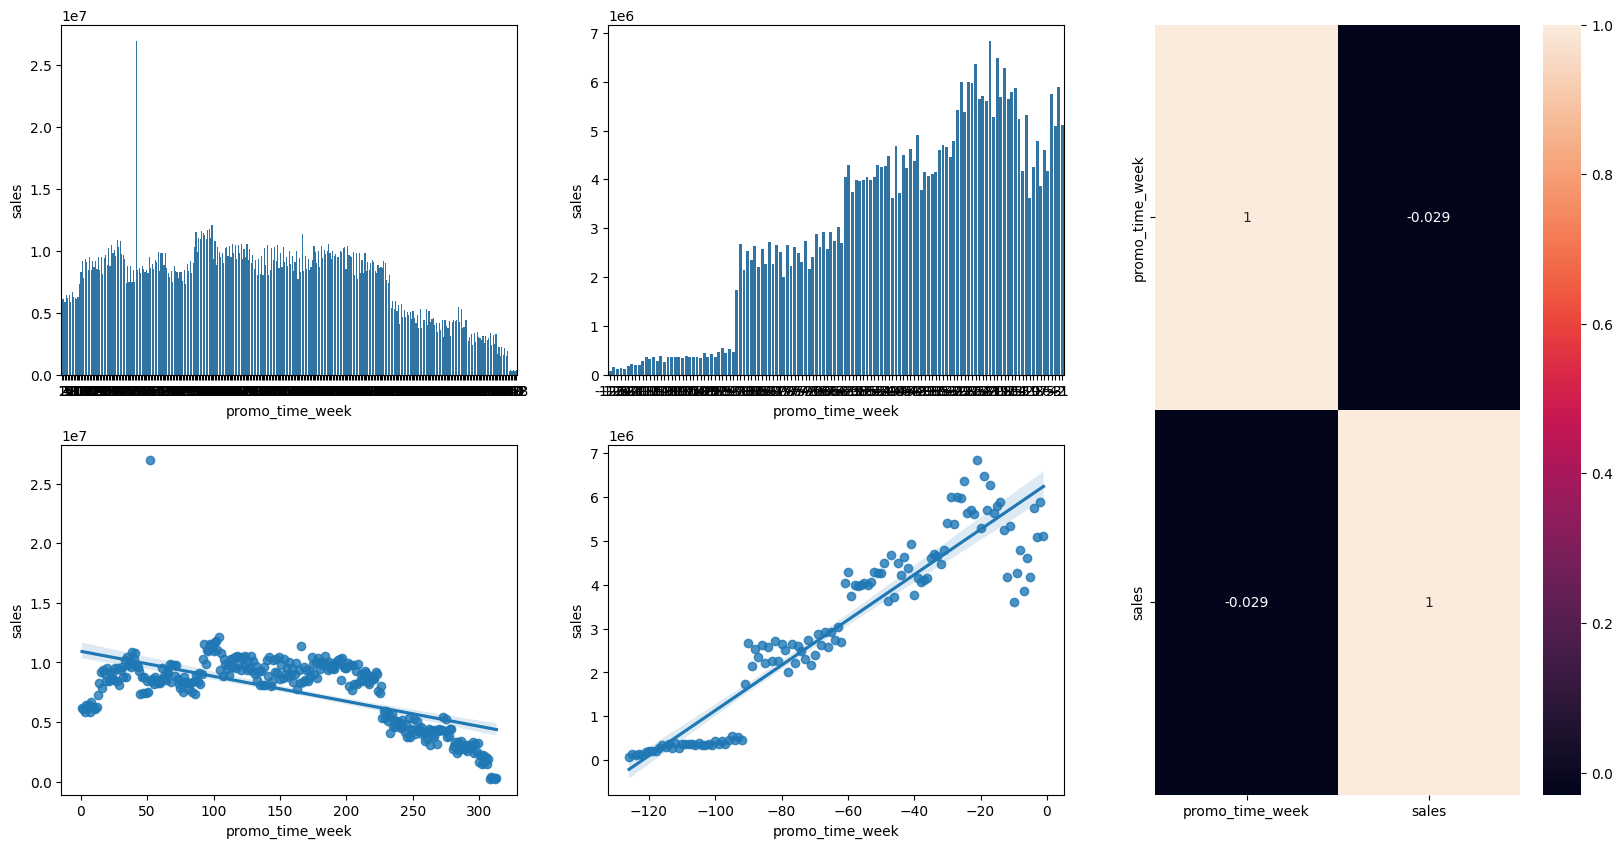

In [46]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week',y='sales', data=aux1);


fig = plt.figure(figsize=(20, 10))  # Definindo o tamanho da figura

grid = GridSpec( 2,3 , figure=fig)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # Promoção Estentida
sns.barplot(x='promo_time_week',y='sales', data=aux2);

plt.subplot(grid[0,1])
aux3 = aux1[aux1['promo_time_week'] < 0] # Promoção Regular
sns.barplot(x='promo_time_week',y='sales', data=aux3);

plt.subplot(grid[1,0])
sns.regplot(x='promo_time_week',y='sales', data=aux2)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson' ), annot=True);

plt.show()


### <s> H5 Lojas com mais dias de promoção deveriam vender mais. </s>

### H6 Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO**

In [47]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index().sort_values(by='sales', ascending=False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


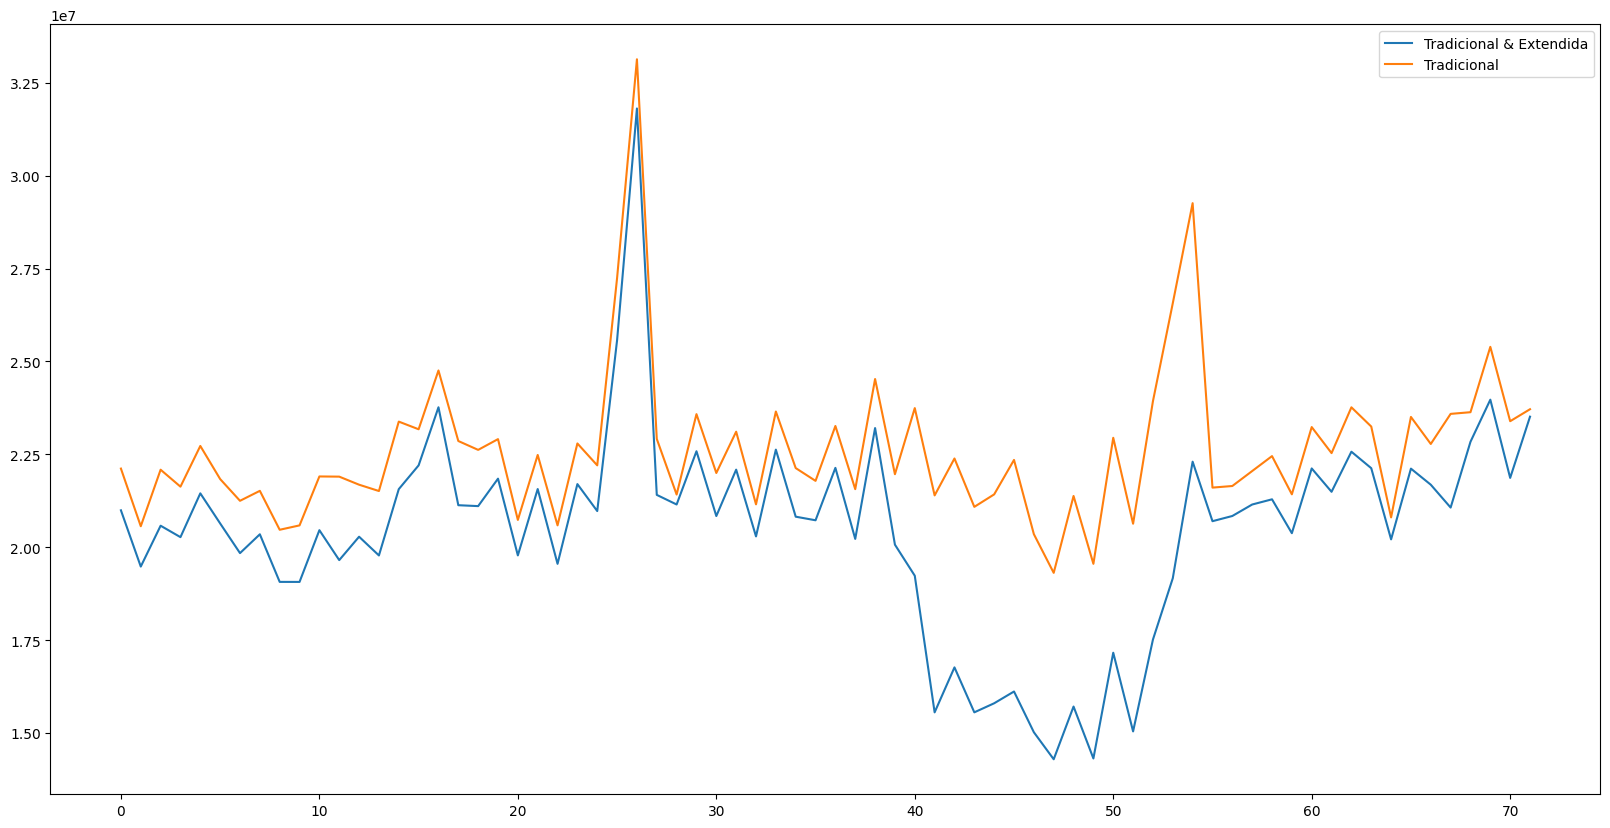

In [48]:
aux1 = df4[( df4['promo'] == 1) & (df4['promo2'] == 1 )][['year_week' , 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(20, 10))

aux2 = df4[( df4['promo'] == 1) & (df4['promo2'] == 0 )][['year_week' , 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Tradicional'])

### H8 Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSO**

<Axes: xlabel='year', ylabel='sales'>

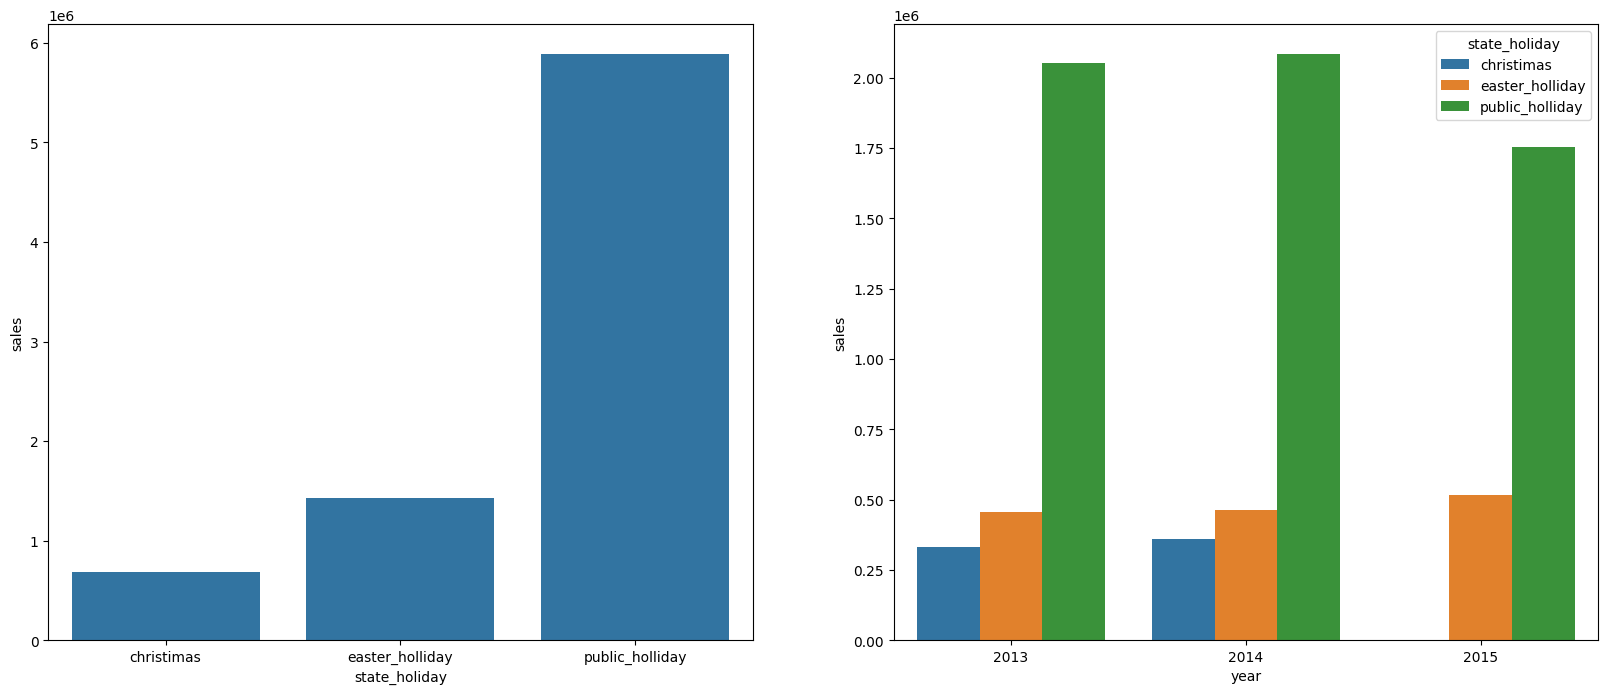

In [49]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby( 'state_holiday' ).sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot( x='state_holiday' , y='sales' , data=aux1)
plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year' , y='sales',hue='state_holiday', data=aux2)

### H9 Lojas deveriam vender mais ao longo dos anos.

**FALSO**

<Axes: >

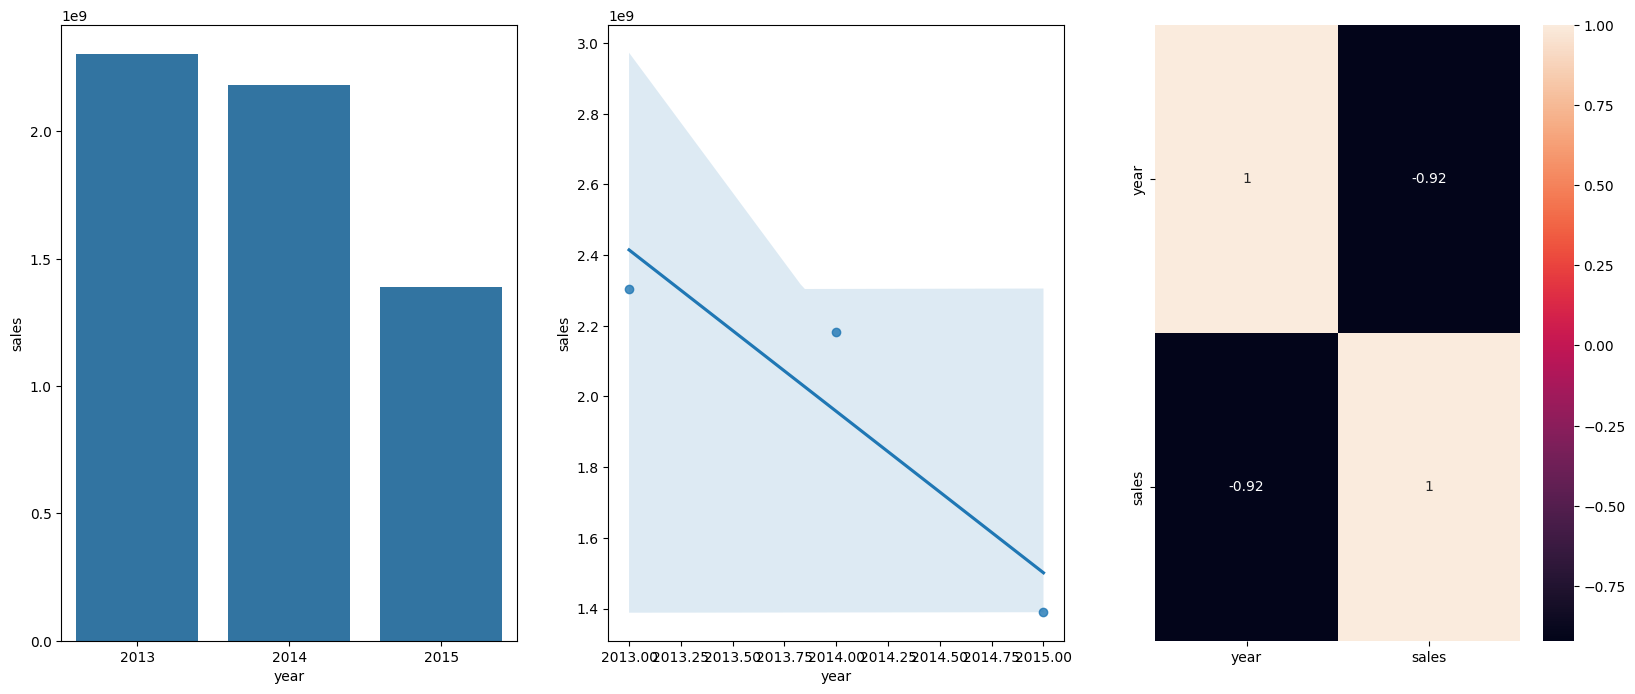

In [50]:
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot( x='year' , y='sales' , data=aux1 )

plt.subplot(1,3,2)
sns.regplot( x='year' , y='sales' , data=aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(), annot=True)

### H10 Lojas deveriam vender mais no segundo semestre do ano.

**FALSO**

<Axes: >

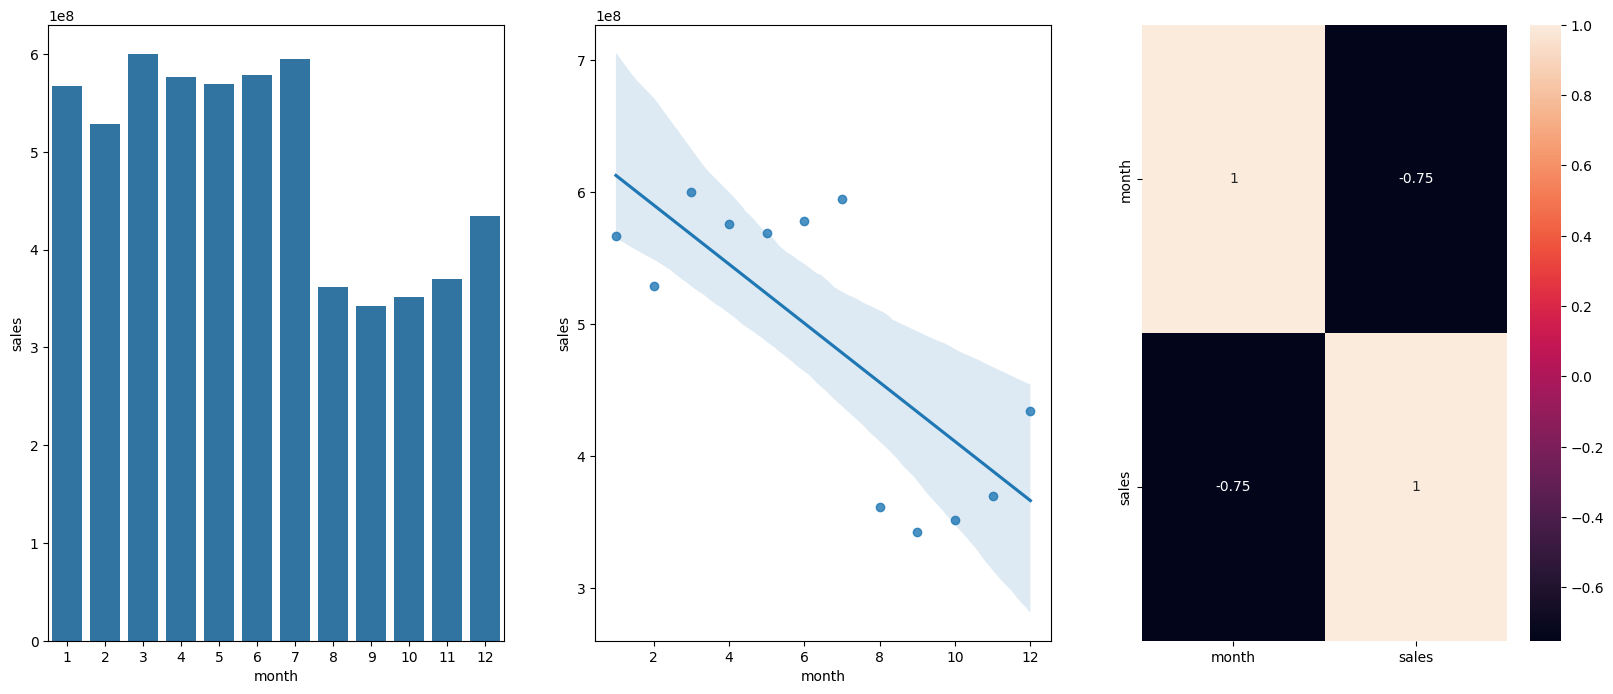

In [51]:
aux1 = df4[['month','sales']].groupby( 'month' ).sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot( x='month' , y='sales' , data=aux1 )

plt.subplot(1,3,2)
sns.regplot( x='month' , y='sales' , data=aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(), annot=True)

### H11 Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA**

<Axes: xlabel='before_after', ylabel='sales'>

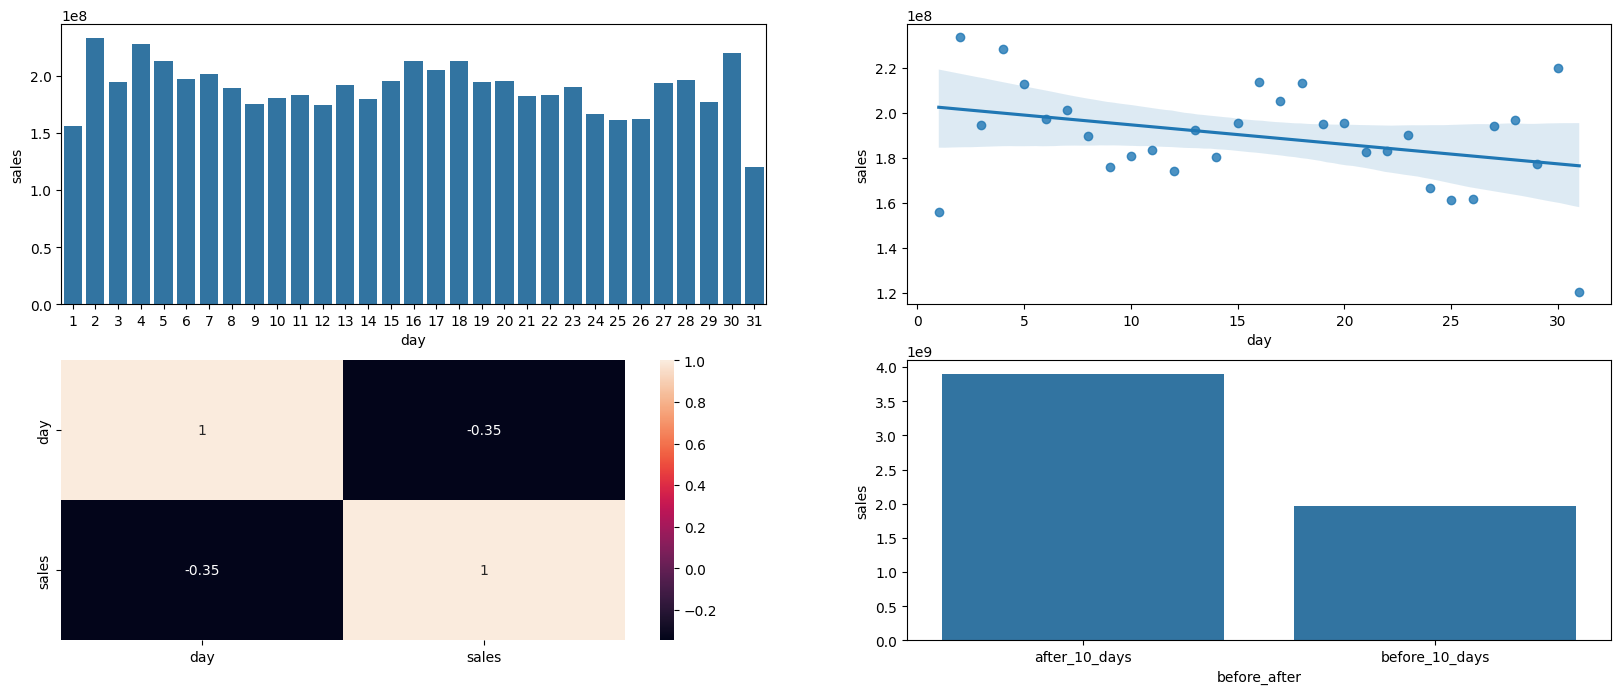

In [52]:
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.barplot( x='day' , y='sales' , data=aux1 )

plt.subplot(2,2,2)
sns.regplot( x='day' , y='sales' , data=aux1 )

plt.subplot(2,2,3)
sns.heatmap( aux1.corr(), annot=True)

plt.subplot(2,2, 4)
aux1['before_after'] =aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =  aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after' , y='sales' , data=aux2 )

### H12 Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA**

<Axes: >

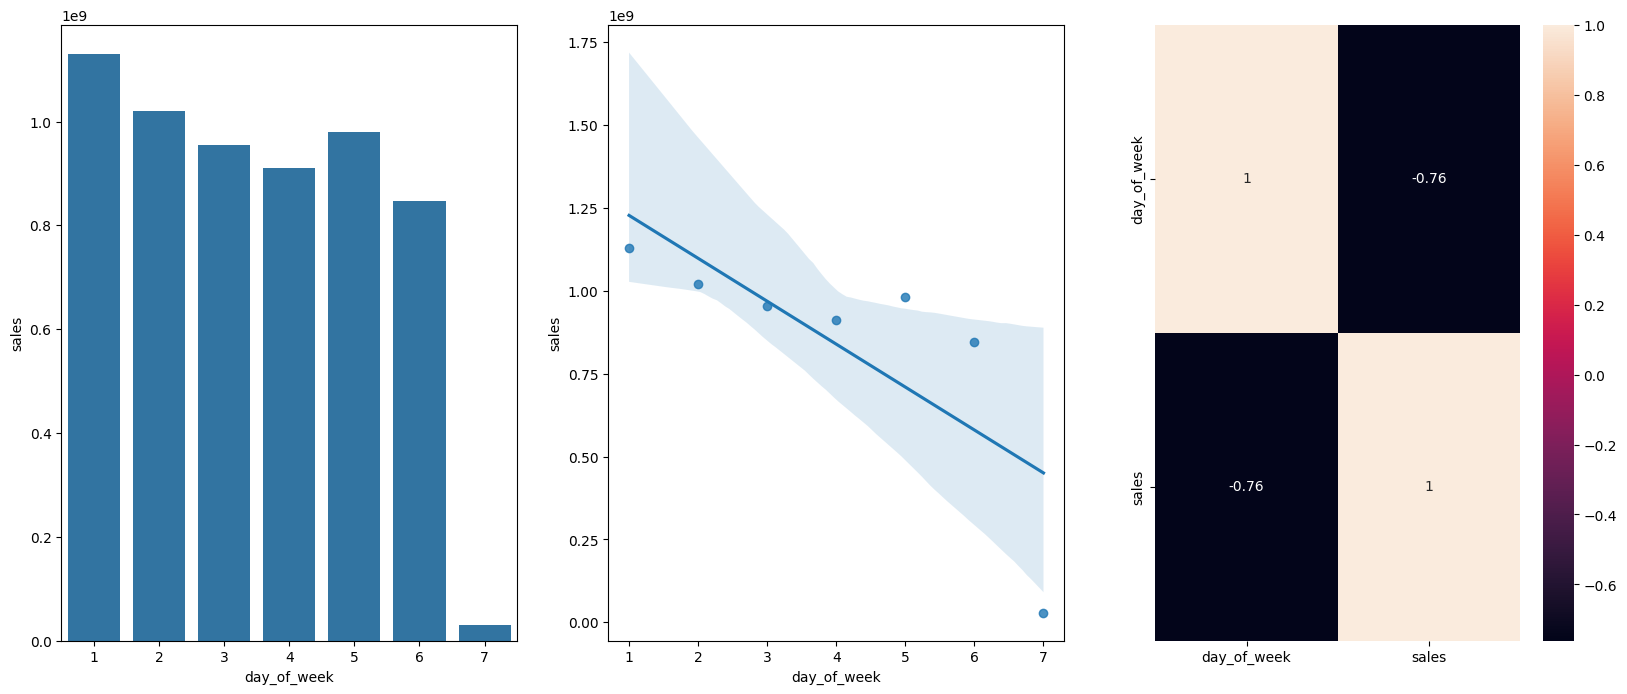

In [53]:
aux1 = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot( x='day_of_week' , y='sales' , data=aux1 )

plt.subplot(1,3,2)
sns.regplot( x='day_of_week' , y='sales' , data=aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(), annot=True)

### H13 Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA**

<Axes: xlabel='month', ylabel='sales'>

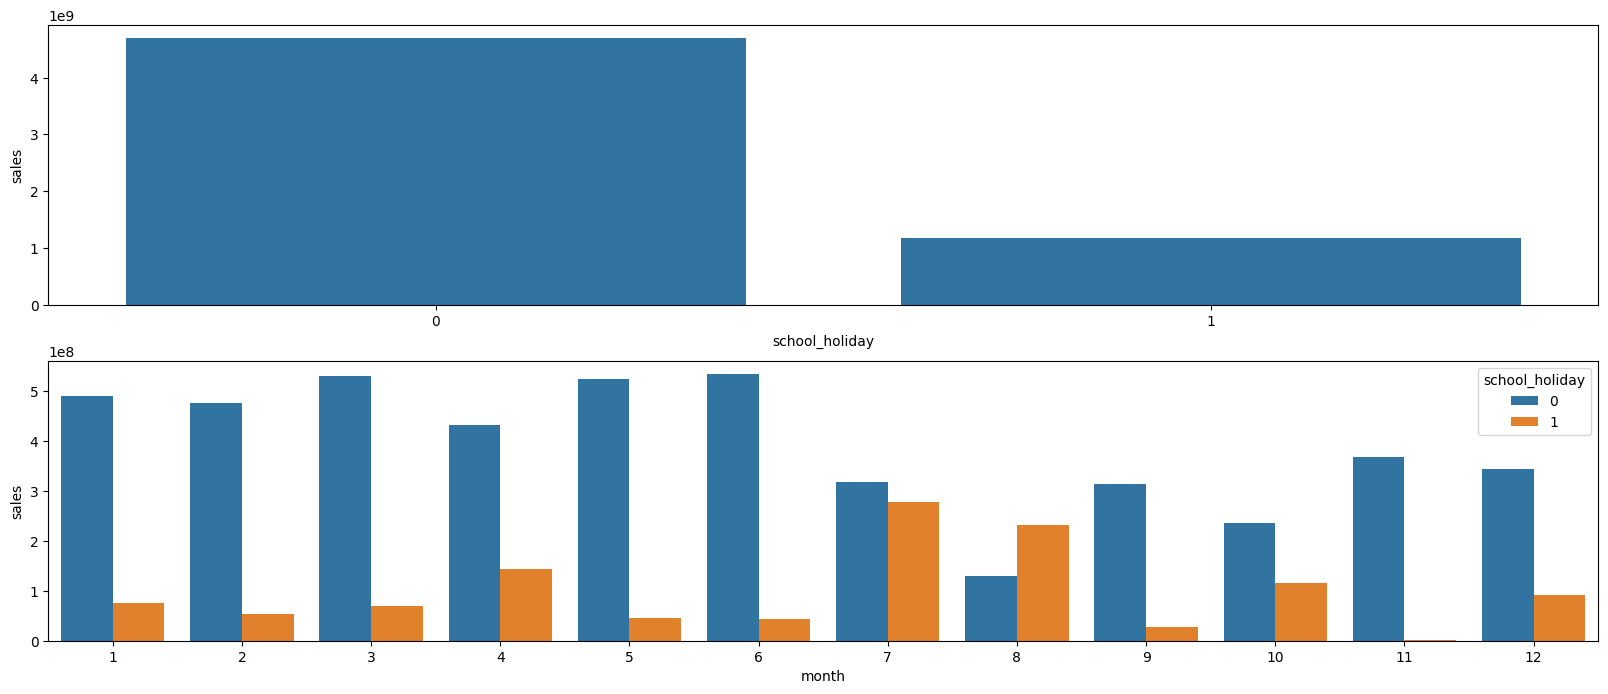

In [54]:
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
sns.barplot( x='school_holiday' , y='sales' , data=aux1 )

aux2 = df4[['month','school_holiday','sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot( x='month' , y='sales' , hue='school_holiday', data=aux2 )

In [55]:
from tabulate import tabulate

In [56]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Multivariada

##### 4.3.1 Numerical Atributes

<Axes: >

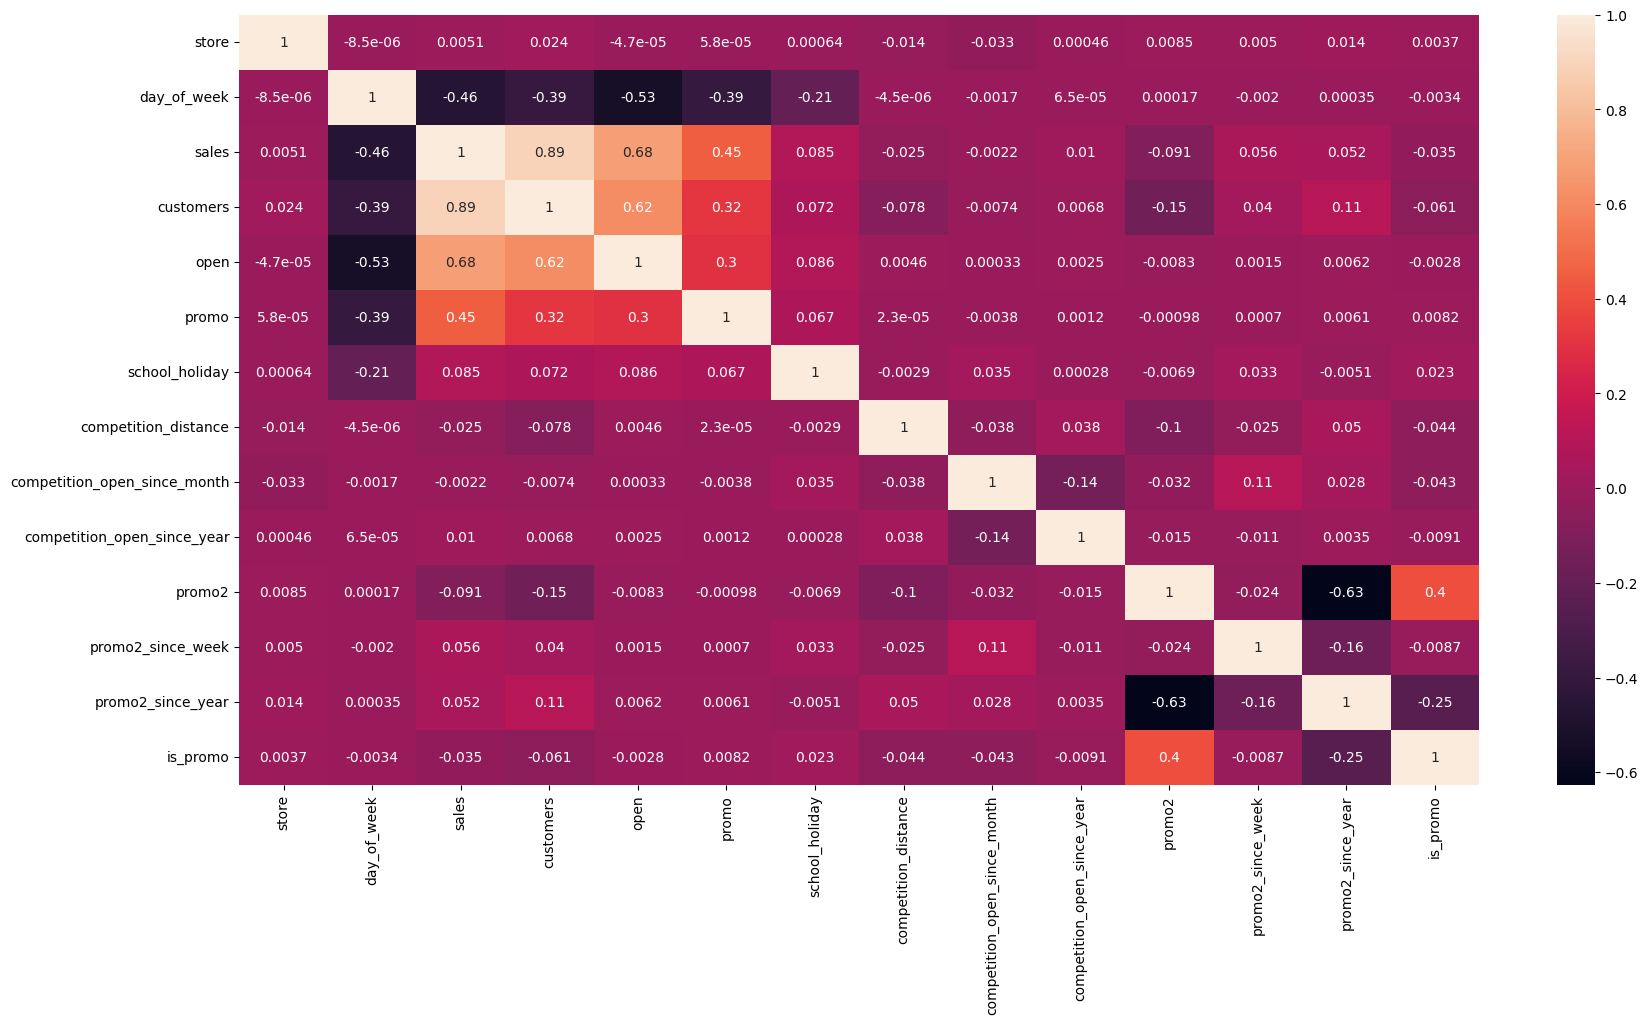

In [57]:
correlation = num_atributes.corr( method='pearson' )
plt.figure(figsize=(20,10))
sns.heatmap(correlation , annot=True)

##### 4.3.1 Categorical Atributes

<Axes: >

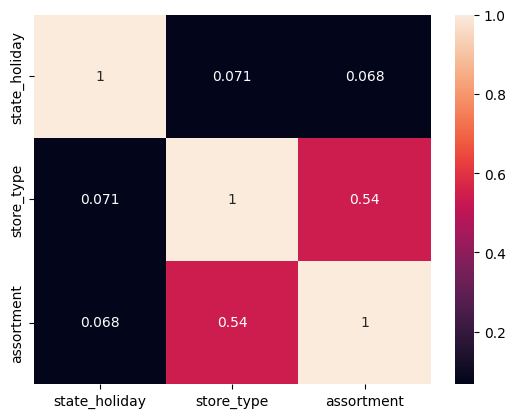

In [58]:
a = df4.select_dtypes( include='object')
#Calculate Cramer V
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])
d = pd.DataFrame(
            {
               'state_holiday': [a1 ,a2 ,a3],
               'store_type': [a4 ,a5 ,a6],
               'assortment': [a7 ,a8 ,a9]
            }
            )
d = d.set_index(d.columns)
sns.heatmap(d , annot=True)

# 5.0 Preparação dos Dados

In [59]:
df5 = df4.copy()

### Descrição

In [60]:
num_atributes = df5.select_dtypes( include=[ 'int64' , 'float64' ] )
cat_atributes = df5.select_dtypes( exclude=[ 'int64' , 'float64' , 'datetime64[ns]' ] )

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_atributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_atributes.apply( np.median ) ).T

# Disprsion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_atributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_atributes.apply( min ) ).T
d3 = pd.DataFrame( num_atributes.apply( max ) ).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [ d2 , d3 , d4 ,ct1 , ct2 , d1 , d5 , d6 ] ).T.reset_index()
m.columns = [ 'Atributes','min', 'max', 'range', 'mean', 'meadian', 'std', 'skew', 'kurtosis']
m

,Atributes,min,max,range,mean,meadian,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


In [61]:
cat_atributes.head()

,state_holiday,store_type,assortment,year,month,day,week_of_year,year_week
0,regular_day,c,basic,2015,7,31,31,2015-30
1,regular_day,a,basic,2015,7,31,31,2015-30
2,regular_day,a,basic,2015,7,31,31,2015-30
3,regular_day,c,extended,2015,7,31,31,2015-30
4,regular_day,a,basic,2015,7,31,31,2015-30


## 5.1 Normalização

Como não temos Variaveis normais, não vamos utilizar a normalização

## 5.2 Rescaling

<Axes: xlabel='year'>

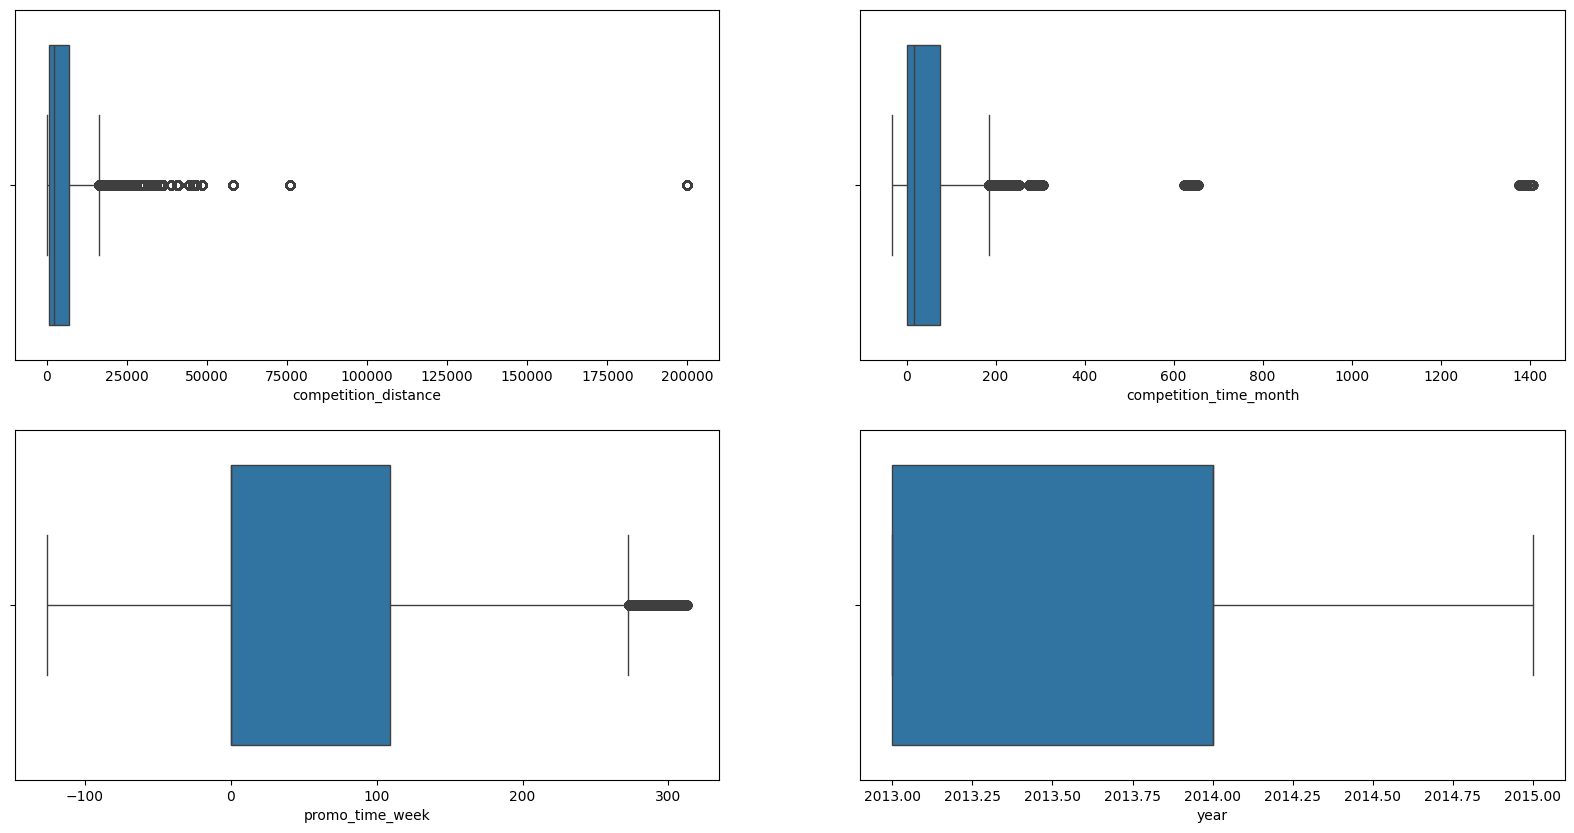

In [62]:
#Verificando outliers para saber qual scalling usar
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.boxplot( x=df5['competition_distance'] )
plt.subplot(2,2,2)
sns.boxplot( x=df5['competition_time_month'] )
plt.subplot(2,2,3)
sns.boxplot( x=df5['promo_time_week'] )
plt.subplot(2,2,4)
sns.boxplot( x=df5['year'] )

In [63]:
rs = RobustScaler()
mm = MinMaxScaler()

# Competition Distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# promo time week
df5['promo_time_week'] = mm.fit_transform( df5[['promo_time_week']].values )  
# Year
df5['year'] = mm.fit_transform( df5[['year']].values )


## 5.3 Transformação

### 5.3.1 Enconding

In [64]:
le = LabelEncoder()
# One Hot Enconding
# State Holiday
df5 = pd.get_dummies(df5, prefix='state_holiday',columns=['state_holiday'])
# Label Encoding
# Store Type
df5['store_type'] = le.fit_transform( df5['store_type'] )
# Ordinal Encoding
assort_dict = { 'basic': 1, 'extended':2 , 'extra': 3 }
df5['assortment'] = df5['assortment'].map(assort_dict)

### 5.3.2 Tranformaçã da Variavel Resposta

In [65]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Transformação de Natureza

In [66]:
#Ciclica Sin and Cosine
# Day Of Week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi / 7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 )))
# Month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 )))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 )))
# Day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi / 30 )))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 )))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 )))

# 6.0 Seleção dos Atributos

In [67]:
df6 = df5.copy()

### 6.1 Split dataframe

In [68]:
cols_drop = ['day_of_week','month','week_of_year','day','promo_since','competition_since','year_week']
df6 = df6.drop( cols_drop, axis=1)

In [69]:
df6[['store','date']].groupby( 'store' ).max().reset_index()['date'][0] - timedelta( days= 6*7 )

Timestamp('2015-06-19 00:00:00')

In [70]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2 Boruta para seleção de variaveis

In [71]:
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

#gambiarra para o boruta funcionar por conta do method do numpy estar deprecado
#np.float = float
#np.int = int
#np.object = object
#np.bool = bool

#rf = RandomForestRegressor(n_jobs=1)
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

#devido a demora do algoritmo de feature selection o mesmo foi comentado para podermos rodar novamente o kernel

### 6.2.1 Best Features Boruta

In [72]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

#cols_not_selected_boruta = np.setdiff1d( X_train_fs.columns,  cols_selected_boruta)

### 6.3 Manual Feature Selection

In [73]:
cols_selected_boruta = [
                        'store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos'
                    ]

#columns_to_add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7. Modelagem de Machine Learning

In [74]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Modelo de média

In [75]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge ( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model' , np.expm1(y_test) , np.expm1(yhat_baseline))

In [76]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Modelo de Regressão Linear

In [77]:
lr = LinearRegression().fit( x_train, y_train )

yhat_lr = lr.predict( x_test )

lr_result = ml_error( 'Linear Regression' , np.expm1(y_test) , np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,2662.291292


## 7.3 Modelo de Regressão Linear Regularizada

In [78]:
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

yhat_lrr = lrr.predict( x_test )

lrr_result = ml_error( 'Linear Regression' , np.expm1(y_test) , np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1891.398669,0.289252,2743.459417


## 7.4 Modelo de Random Forest Regressor

In [79]:
rf = RandomForestRegressor( n_estimators=100 , n_jobs=1 , random_state=42 ).fit( x_train, y_train )

yhat_rf = rf.predict( x_test )

rf_result = ml_error( 'Random Forest Regressor' , np.expm1(y_test) , np.expm1(yhat_rf))
rf_result

## 7.5 Modelo de XGBoost Regressor

In [ ]:
xgbr = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=100,
                        eta=0.01,
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytee=0.9,
                        n_jobs=1,
                        random_state=42 )\
                        .fit( x_train, y_train )

yhat_xgb = xgbr.predict( x_test )

xgb_result = ml_error( 'XGBoost Regressor' , np.expm1(y_test) , np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1694.375243,0.251545,2476.266749


## 7.6 Comparando performance de todos os modelos

In [ ]:
modeling_result = pd.concat( [ baseline_result , lr_result , lrr_result , rf_result , xgb_result ])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.010654,0.099924,1012.096749
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1694.375243,0.251545,2476.266749
0,Linear Regression,1861.127229,0.291652,2662.291292
0,Linear Regression,1891.398669,0.289252,2743.459417


# 8. Aplicando Validação Cruzada

In [ ]:
x_training = X_train[ cols_selected_boruta_full ]

## 8.1. regressão Linear

In [ ]:
model = LinearRegression()
lr_result_cv = time_cross_validation( x_training, 5, 'LinearRegression', model)
lr_result_cv

,Model_NAME,MAE CV,MApE CV,RMSE CV
0,LinearRegression,1988.17+/-41.87,0.29+/-0.01,2838.73+/-87.93


## 8.2. Lasso

In [ ]:
model = Lasso( alpha=0.01 )
lrr_result_cv = time_cross_validation( x_training, 5, 'Lasso', model)
lrr_result_cv

,Model_NAME,MAE CV,MApE CV,RMSE CV
0,Lasso,2036.93+/-54.23,0.29+/-0.0,2964.41+/-90.09


## 8.3. Random Forest

In [ ]:
model = RandomForestRegressor( n_estimators=100 , n_jobs=1 , random_state=42 )
rf_result_cv = time_cross_validation( x_training, 5, 'Random Forest', model, verbose=True)
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model_NAME,MAE CV,MApE CV,RMSE CV
0,Random Forest,830.48+/-105.42,0.12+/-0.02,1265.16+/-191.02


## 8.4. XGBoost Regressor

In [ ]:
model = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=100,
                        eta=0.01,
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytee=0.9,
                        n_jobs=1,
                        random_state=42 )\
                        .fit( x_train, y_train )

xgb_result_cv = time_cross_validation( x_training, 5, 'XGBoost', model)
xgb_result_cv

,Model_NAME,MAE CV,MApE CV,RMSE CV
0,XGBoost,1806.45+/-45.28,0.25+/-0.0,2635.38+/-74.8


### 8.5 Comparando Resultados

In [ ]:
modeling_result_cv = pd.concat( [ lr_result_cv , lrr_result_cv , rf_result_cv , xgb_result_cv ])
modeling_result_cv

,Model_NAME,MAE CV,MApE CV,RMSE CV
0,LinearRegression,1988.17+/-41.87,0.29+/-0.01,2838.73+/-87.93
0,Lasso,2036.93+/-54.23,0.29+/-0.0,2964.41+/-90.09
0,Random Forest,830.48+/-105.42,0.12+/-0.02,1265.16+/-191.02
0,XGBoost,1806.45+/-45.28,0.25+/-0.0,2635.38+/-74.8


# 9.0 Fine Tuning

## 9.1. Random Search

In [ ]:
param =  {
    'n_estimators': [1500, 1700, 2500, 3000, 2500],
    'eta':[0.01, 0.03],
    'max_depth':[3, 5, 9],
    'subsample':[0.1,0.5,0.7],
    'colsample_bytee':[0.3, 0.7, 0.9],
    'n_jobs':[1],
    'min_child_weight':[3,8,15]
        }

MAX_EVAL = 2

In [ ]:
final_result = pd.Dataframe()

for i in range ( MAX_EVAL ):
    hp = { k: random.sample( v, 1 )[0] for k , v in param.items() }
    print(hp)

    model = xgb.XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators=hp['n_estimators'],
                            eta=hp['eta'],
                            max_depth=hp['max_depth'],
                            subsample=hp['subsample'],
                            colsample_bytee=hp['colsample_bytee'],
                            n_jobs=hp['n_jobs'],
                            min_child_weight=hp['min_child_weight'],
                            random_state=42 )

    result = time_cross_validation( x_training, 5, 'XGBoost', model, verbose=True)
    pd.copncat([final_result , result])

final_result


AttributeError: module 'pandas' has no attribute 'Dataframe'

## 9.2. Final Model

In [ ]:
param_tuned =  {
    'n_estimators': ,
    'eta':,
    'max_depth':,
    'subsample':[,
    'colsample_bytee':,
    'n_jobs':,
    'min_child_weight':
        }

MAX_EVAL = 2

In [ ]:
model_xgb_tuned = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=hp['n_estimators'],
                        eta=hp['eta'],
                        max_depth=hp['max_depth'],
                        subsample=hp['subsample'],
                        colsample_bytee=hp['colsample_bytee'],
                        n_jobs=hp['n_jobs'],
                        min_child_weight=hp['min_child_weight'],
                        random_state=42 ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

result_xgb_tuned = ml_error(" XGBoost Regressor", np.exprm1( y_test) , np.exprm1( yhat_xgb_tuned ))

result_xgb_tuned


AttributeError: module 'pandas' has no attribute 'Dataframe'